# In the notebook, a model is trained for each medicine

data source: ./simplified_data/simplified_data2.csv

the last few blocks were commmented since I have no clue what they were for.




## Setting:

layer: 64-32-16-2

# 0. Global Variables

In [1]:
# Remove the entire column related to a specific medicine if its occurrence is below the defined threshold.
# In the given dataset, setting this threshold to 250 would retain columns for only the top 10 most frequently used medicines.
DeleteMedThreshold = 0

# Determine the number of medicines to be trained as output
# The total number of medicine is 102
NumMedTrain =102

# Decide whether to enhance accuracy by utilizing class weights
UseClassWeight = False

# Decide learning_rate
LearningRate = 0.005

# layer we are going to use: 64-32-16-2

# 1. Import module


In [2]:

# Importing necessary libraries
import numpy as np
import pandas as pd
import statistics
from tabulate import tabulate
import matplotlib.pyplot as plt

# Importing TensorFlow for deep learning
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

# Importing scikit-learn for data preprocessing and utilities
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight

# Importing custom utility functions
from utility_file import my_utilities as myutil
from utility_file import load_data

# 2. Read Data
Load the data using the custom module "load_data"

In [3]:
# Load data for training a model with one specific medicine, including debugging information
(X_np, X_val_np, train_y, val_y, 
 num_col_x, num_1_valy, num_0_valy) = load_data.load_data_for_1_med_with_debug(del_med_thres=DeleteMedThreshold, 
                                                                               random_seed=3, 
                                                                               n=NumMedTrain, 
                                                                               file_name='raw_data/process_data.csv',
                                                                               use_text_convert=True)

# Ensure the correct data types for loaded variables
assert isinstance(X_np, np.ndarray)
assert isinstance(X_val_np, np.ndarray)
assert isinstance(train_y, pd.DataFrame)
assert isinstance(val_y, pd.DataFrame)
assert isinstance(num_col_x, int)


--------------------------------------------------------------------------------
ReadData:
Type of data: <class 'pandas.core.frame.DataFrame'>
Shape of data = (797 rows, 227 cols).
End of ReadData
--------------------------------------------------------------------------------
SplitXY:
Shape of X = (796 rows, 120 cols).
Shape of y = (796 rows, 102 cols).
End of SplitXY
--------------------------------------------------------------------------------
In load_data_for_1_med_with_debug of load_data.py, random_seed= 3
After SplitXY, total number of 0, 1 in y:
Number of 0s: 72318
Number of 1s: 8874
save med num done
Train_X.shape:  (637, 120)
Train_y.shape:  (637, 102)

Split Training Validation
Number of 0s in train_y: 57813
Number of 1s train_y: 7161
Number of 0s in val_y: 14505
Number of 1s val_y: 1713
--------------------------------------------------------------------------------


# 3. Data Type Checking

In [4]:
# Uncomment the line below to display the DataFrame content and structure
# myutil.print_df(val_y, "---- y ----")

# Uncomment the line below to print the DataFrame directly
# print(val_y)

# Checking:

# Counting NA values in y
na_count = val_y.isna().sum().sum()

# Counting str values in y
str_count = val_y[val_y.map(type) == str].count().sum()

# Counting int values in y
int_count = val_y[val_y.map(type) == int].count().sum()

# Counting float values in y
float_count = val_y[val_y.map(type) == float].count().sum()

# Display the results
print(f"Number of NA values in y: {na_count}")
print(f"Number of str values in y: {str_count}")
print(f"Number of int values in y: {int_count}")
print(f"Number of float values in y: {float_count}")


Number of NA values in y: 0
Number of str values in y: 0
Number of int values in y: 16218
Number of float values in y: 0


# 4. Compute Class Weight

In [5]:
# Convert the 'train_y' DataFrame to a NumPy array
train_y_np = np.array(train_y)

# Determine the number of labels (columns) in the array
num_labels = train_y_np.shape[1]

# Initialize an empty dictionary to store class weights for each label
class_weight_dic = {}

# Iterate over each label column
for i in range(num_labels):
    # Count the occurrences of each class (0 and 1) in the current label column
    unique_values, counts = np.unique(train_y_np[:, i], return_counts=True)
    
    # Create a dictionary mapping class values to their frequencies
    value_frequency_dict = dict(zip(unique_values, counts))
    
    # Calculate the total number of occurrences for normalization
    total = value_frequency_dict.get(0, 0) + value_frequency_dict.get(1, 0)
    
    # Calculate class weights and store them in the dictionary
    class_weight_dic[i] = {0: (value_frequency_dict.get(1, 0) / total), 1: (value_frequency_dict.get(0, 0) / total)}

# Display the computed class weights
print(class_weight_dic)

{0: {0: 0.152276295133438, 1: 0.847723704866562}, 1: {0: 0.4301412872841444, 1: 0.5698587127158555}, 2: {0: 0.023547880690737835, 1: 0.9764521193092621}, 3: {0: 0.05337519623233909, 1: 0.9466248037676609}, 4: {0: 0.31711145996860285, 1: 0.6828885400313972}, 5: {0: 0.009419152276295133, 1: 0.9905808477237049}, 6: {0: 0.2794348508634223, 1: 0.7205651491365777}, 7: {0: 0.05023547880690738, 1: 0.9497645211930926}, 8: {0: 0.018838304552590265, 1: 0.9811616954474097}, 9: {0: 0.018838304552590265, 1: 0.9811616954474097}, 10: {0: 0.3359497645211931, 1: 0.6640502354788069}, 11: {0: 0.02040816326530612, 1: 0.9795918367346939}, 12: {0: 0.13657770800627944, 1: 0.8634222919937206}, 13: {0: 0.16326530612244897, 1: 0.8367346938775511}, 14: {0: 0.09419152276295134, 1: 0.9058084772370487}, 15: {0: 0.02511773940345369, 1: 0.9748822605965463}, 16: {0: 0.0141287284144427, 1: 0.9858712715855573}, 17: {0: 0.015698587127158554, 1: 0.9843014128728415}, 18: {0: 0.1130298273155416, 1: 0.8869701726844584}, 19: {

# 5. Build Model

In [6]:
# Define a Sequential model
model = Sequential([
    Dense(units=64, input_shape=(num_col_x,), activation='sigmoid'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='sigmoid'),
    Dense(units=2, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with specified optimizer, loss function, and metrics
model.compile(optimizer=Adam(learning_rate=LearningRate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7744      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 10,386
Trainable params: 10,386
Non-trainable params: 0
_________________________________________________________________


# 6. Train Model
There will be a model for each medicine

Processing medicine 1 of 102: 麻黃
Training stopped at epoch 273
5/5 [==============================] - 0s 4ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40635 (\N{CJK UNIFIED IDEOGRAPH-9EBB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40643 (\N{CJK UNIFIED IDEOGRAPH-9EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


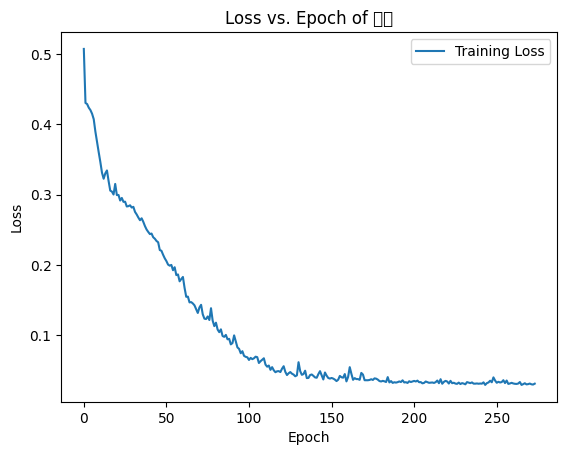

Processing medicine 2 of 102: 桂枝
Training stopped at epoch 183
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26690 (\N{CJK UNIFIED IDEOGRAPH-6842}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26525 (\N{CJK UNIFIED IDEOGRAPH-679D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


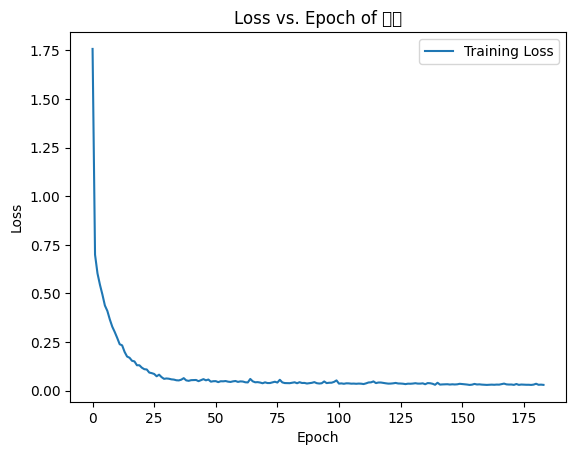

Processing medicine 3 of 102: 荊芥
Training stopped at epoch 111
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33610 (\N{CJK UNIFIED IDEOGRAPH-834A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33445 (\N{CJK UNIFIED IDEOGRAPH-82A5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


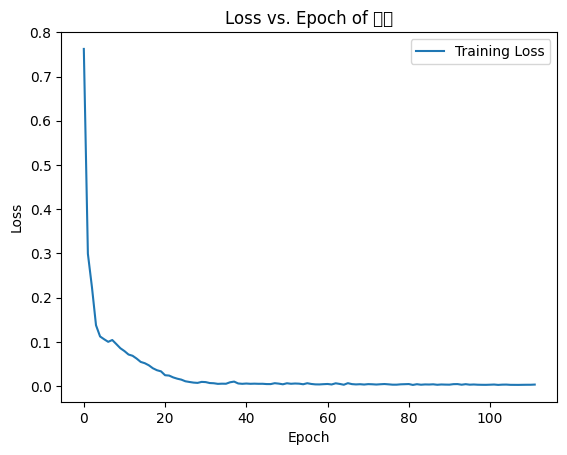

Processing medicine 4 of 102: 防風
Training stopped at epoch 137
5/5 [==============================] - 0s 752us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39080 (\N{CJK UNIFIED IDEOGRAPH-98A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


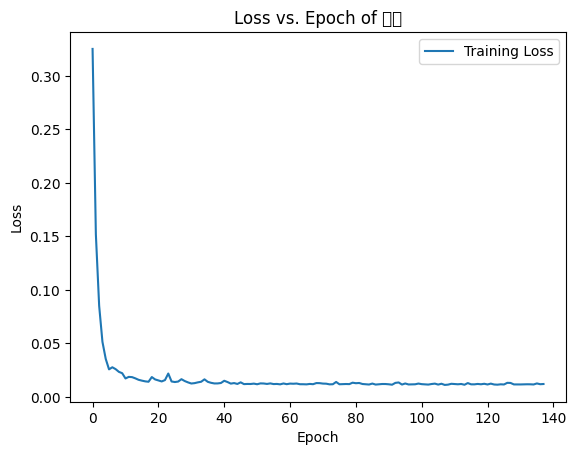

Processing medicine 5 of 102: 細辛
Training stopped at epoch 187
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32048 (\N{CJK UNIFIED IDEOGRAPH-7D30}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36763 (\N{CJK UNIFIED IDEOGRAPH-8F9B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


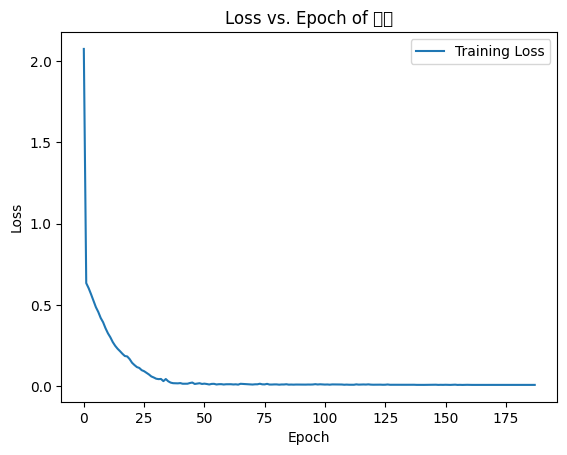

Processing medicine 6 of 102: 白芷
Training stopped at epoch 85
5/5 [==============================] - 0s 753us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33463 (\N{CJK UNIFIED IDEOGRAPH-82B7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


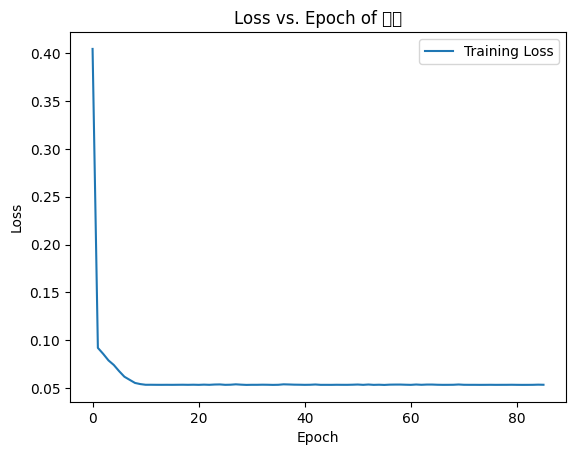

Processing medicine 7 of 102: 生薑
Training stopped at epoch 34
5/5 [==============================] - 0s 1000us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34193 (\N{CJK UNIFIED IDEOGRAPH-8591}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


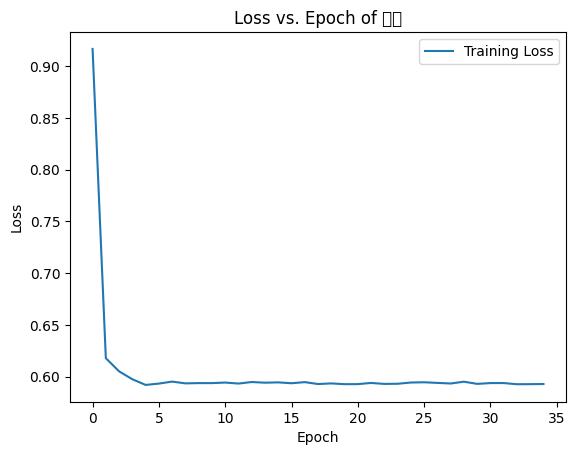

Processing medicine 8 of 102: 辛夷
Training stopped at epoch 66
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22839 (\N{CJK UNIFIED IDEOGRAPH-5937}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


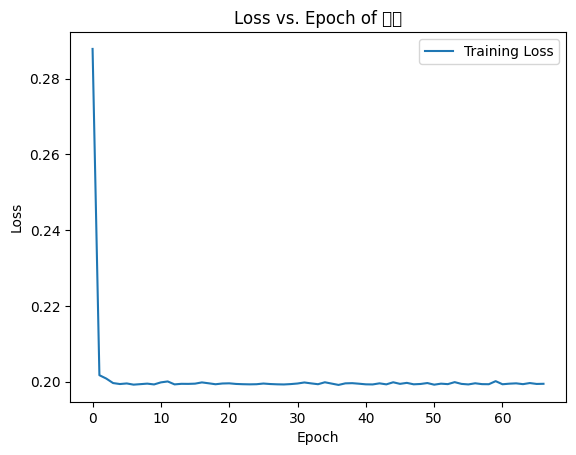

Processing medicine 9 of 102: 葛根
Training stopped at epoch 63
5/5 [==============================] - 0s 750us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33883 (\N{CJK UNIFIED IDEOGRAPH-845B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26681 (\N{CJK UNIFIED IDEOGRAPH-6839}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


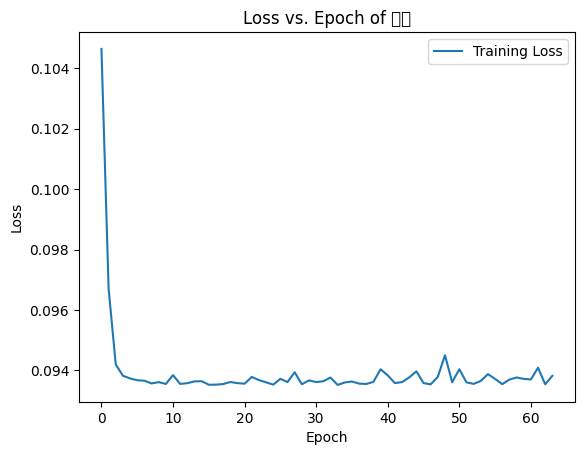

Processing medicine 10 of 102: 升麻
Training stopped at epoch 39
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21319 (\N{CJK UNIFIED IDEOGRAPH-5347}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


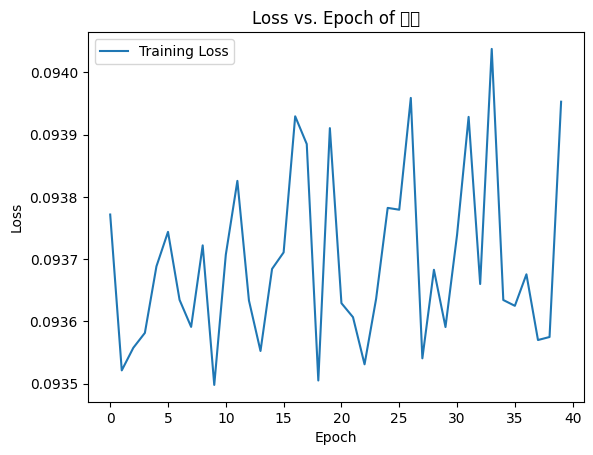

Processing medicine 11 of 102: 柴胡
Training stopped at epoch 41
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26612 (\N{CJK UNIFIED IDEOGRAPH-67F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32993 (\N{CJK UNIFIED IDEOGRAPH-80E1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


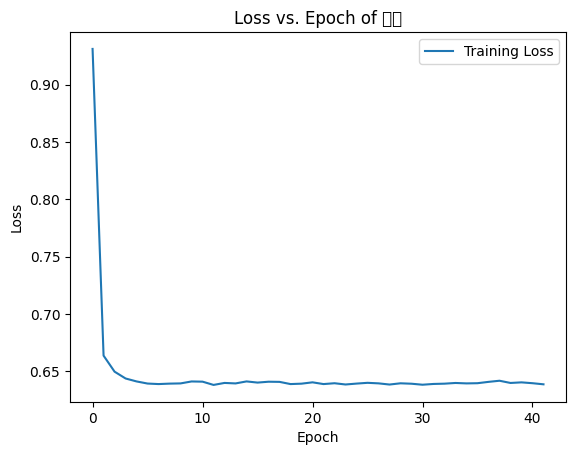

Processing medicine 12 of 102: 蟬蛻
Training stopped at epoch 60
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34796 (\N{CJK UNIFIED IDEOGRAPH-87EC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34555 (\N{CJK UNIFIED IDEOGRAPH-86FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


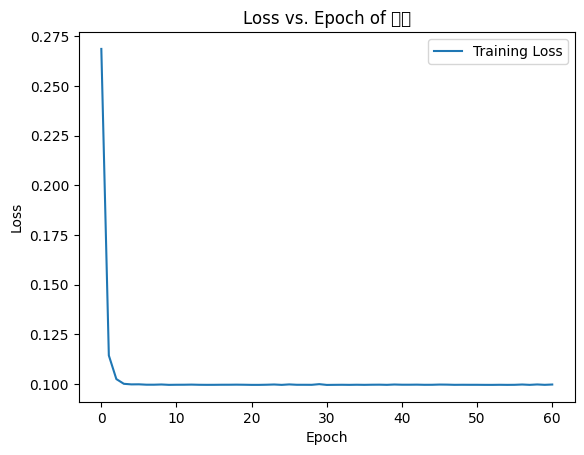

Processing medicine 13 of 102: 石膏
Training stopped at epoch 63
5/5 [==============================] - 0s 750us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33167 (\N{CJK UNIFIED IDEOGRAPH-818F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


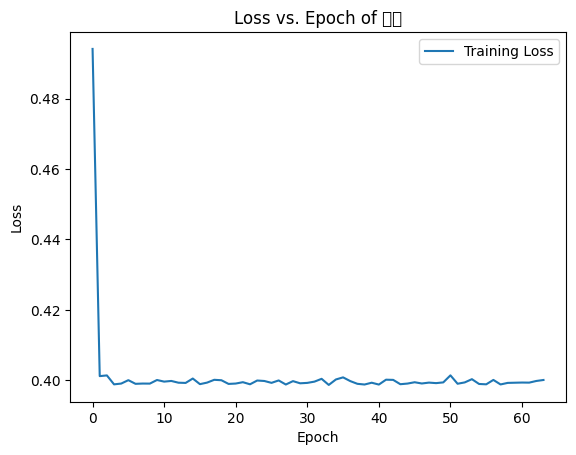

Processing medicine 14 of 102: 知母
Training stopped at epoch 35
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30693 (\N{CJK UNIFIED IDEOGRAPH-77E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27597 (\N{CJK UNIFIED IDEOGRAPH-6BCD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


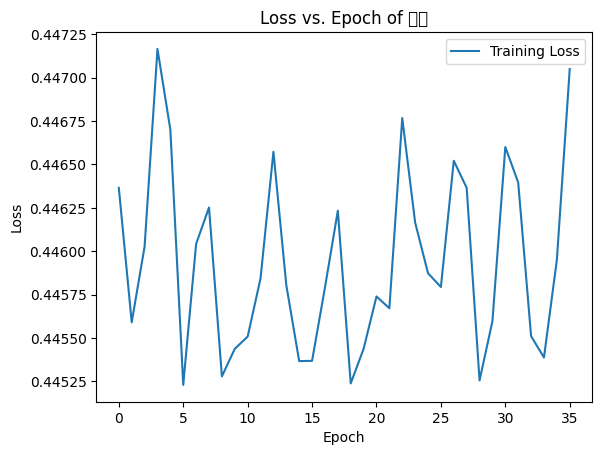

Processing medicine 15 of 102: 梔子
Training stopped at epoch 142
5/5 [==============================] - 0s 750us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26772 (\N{CJK UNIFIED IDEOGRAPH-6894}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


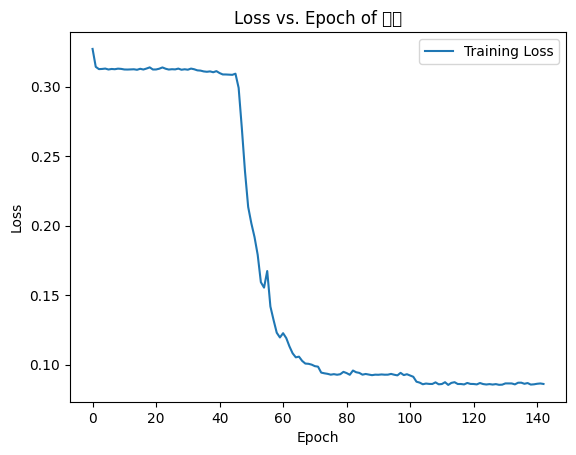

Processing medicine 16 of 102: 天花粉
Training stopped at epoch 100
5/5 [==============================] - 0s 749us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33457 (\N{CJK UNIFIED IDEOGRAPH-82B1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


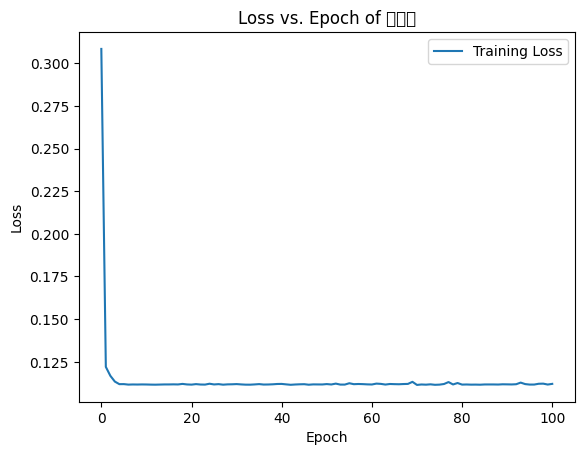

Processing medicine 17 of 102: 夏枯草
Training stopped at epoch 58
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22799 (\N{CJK UNIFIED IDEOGRAPH-590F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26543 (\N{CJK UNIFIED IDEOGRAPH-67AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


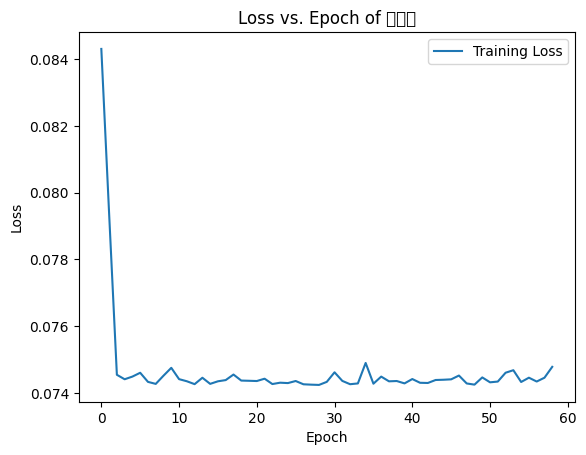

Processing medicine 18 of 102: 決明子
Training stopped at epoch 31
5/5 [==============================] - 0s 1000us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27770 (\N{CJK UNIFIED IDEOGRAPH-6C7A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


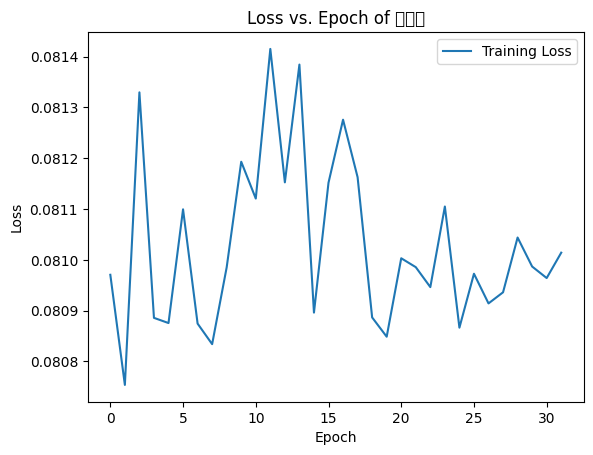

Processing medicine 19 of 102: 生地
Training stopped at epoch 265
5/5 [==============================] - 0s 749us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


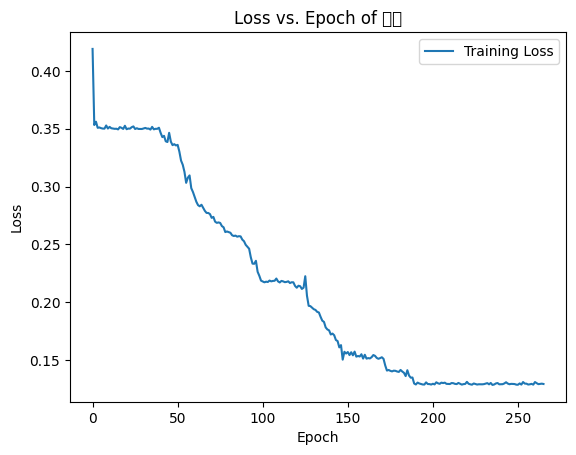

Processing medicine 20 of 102: 牡丹皮
Training stopped at epoch 57
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29281 (\N{CJK UNIFIED IDEOGRAPH-7261}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20025 (\N{CJK UNIFIED IDEOGRAPH-4E39}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30382 (\N{CJK UNIFIED IDEOGRAPH-76AE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


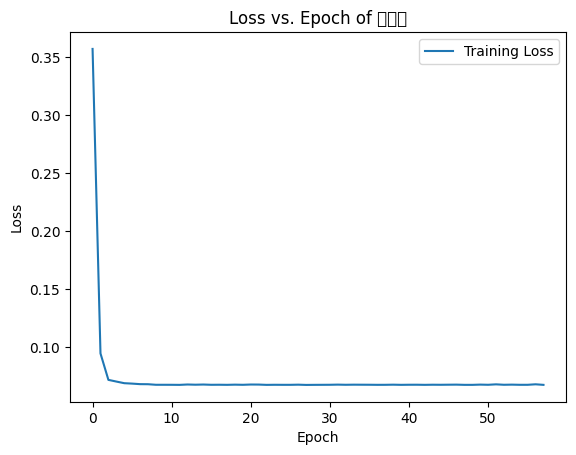

Processing medicine 21 of 102: 連翹
Training stopped at epoch 53
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32761 (\N{CJK UNIFIED IDEOGRAPH-7FF9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


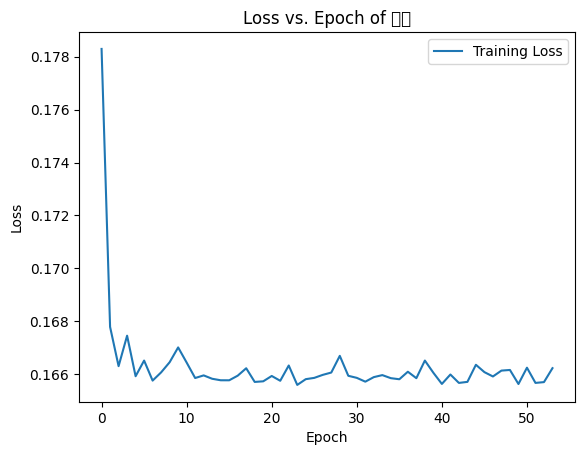

Processing medicine 22 of 102: 射干
Training stopped at epoch 40
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23556 (\N{CJK UNIFIED IDEOGRAPH-5C04}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


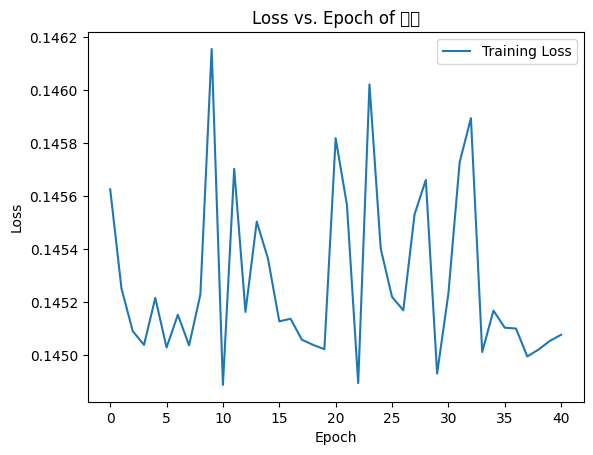

Processing medicine 23 of 102: 黃連
Training stopped at epoch 209
5/5 [==============================] - 0s 1000us/step


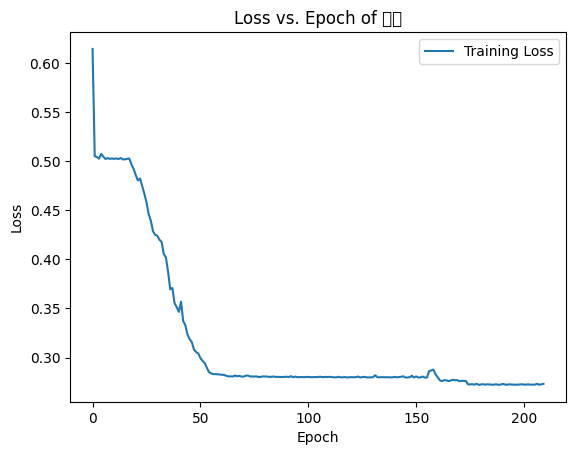

Processing medicine 24 of 102: 黃芩
Training stopped at epoch 221
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33449 (\N{CJK UNIFIED IDEOGRAPH-82A9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


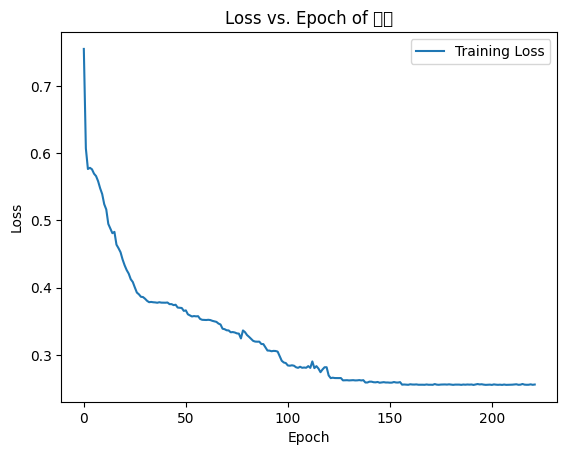

Processing medicine 25 of 102: 黃柏
Training stopped at epoch 79
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26575 (\N{CJK UNIFIED IDEOGRAPH-67CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


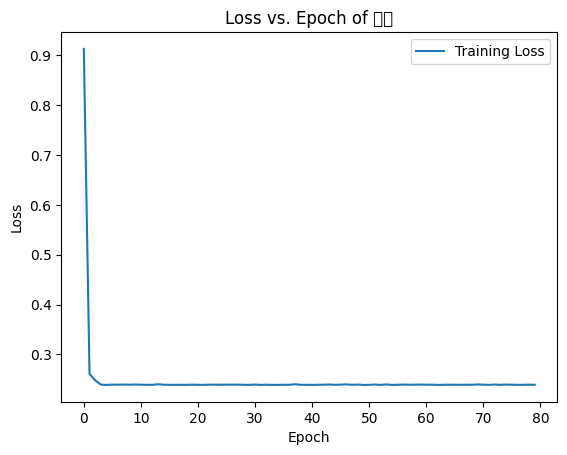

Processing medicine 26 of 102: 龍膽草
Training stopped at epoch 59
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40845 (\N{CJK UNIFIED IDEOGRAPH-9F8D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33213 (\N{CJK UNIFIED IDEOGRAPH-81BD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


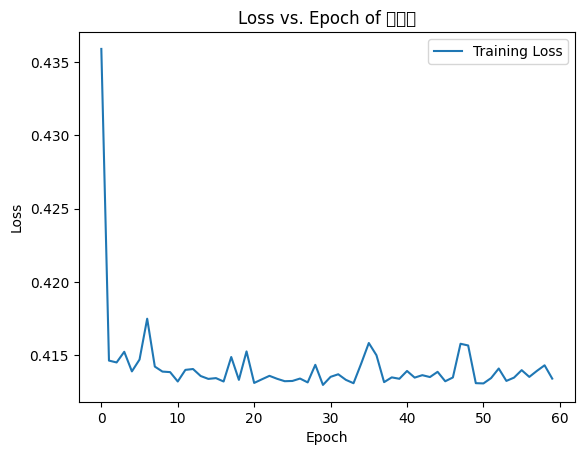

Processing medicine 27 of 102: 大黃
Training stopped at epoch 66
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


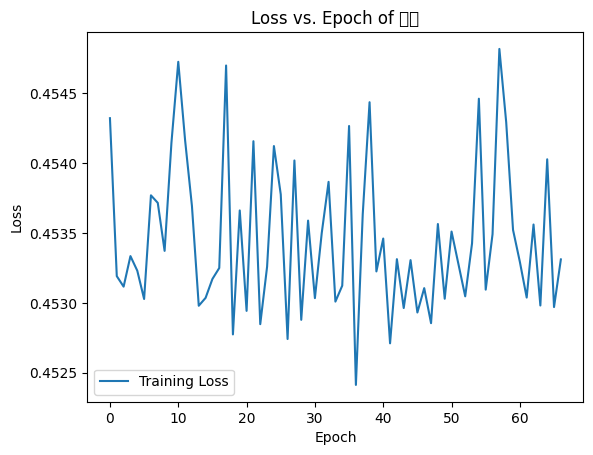

Processing medicine 28 of 102: 芒硝
Training stopped at epoch 60
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33426 (\N{CJK UNIFIED IDEOGRAPH-8292}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30813 (\N{CJK UNIFIED IDEOGRAPH-785D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


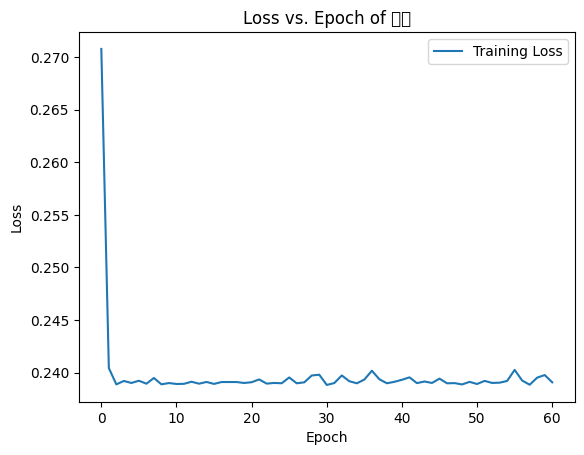

Processing medicine 29 of 102: 防己
Training stopped at epoch 31
5/5 [==============================] - 0s 752us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24049 (\N{CJK UNIFIED IDEOGRAPH-5DF1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


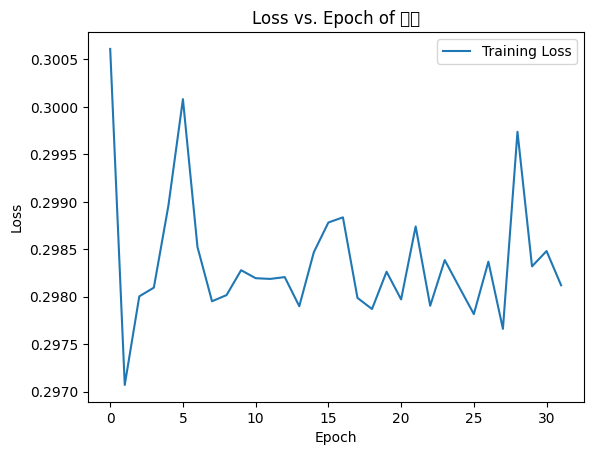

Processing medicine 30 of 102: 秦艽
Training stopped at epoch 130
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31206 (\N{CJK UNIFIED IDEOGRAPH-79E6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33405 (\N{CJK UNIFIED IDEOGRAPH-827D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


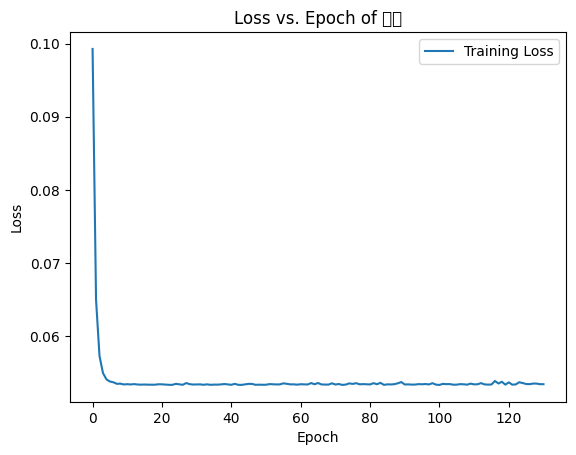

Processing medicine 31 of 102: 絡石藤
Training stopped at epoch 70
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32097 (\N{CJK UNIFIED IDEOGRAPH-7D61}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34276 (\N{CJK UNIFIED IDEOGRAPH-85E4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


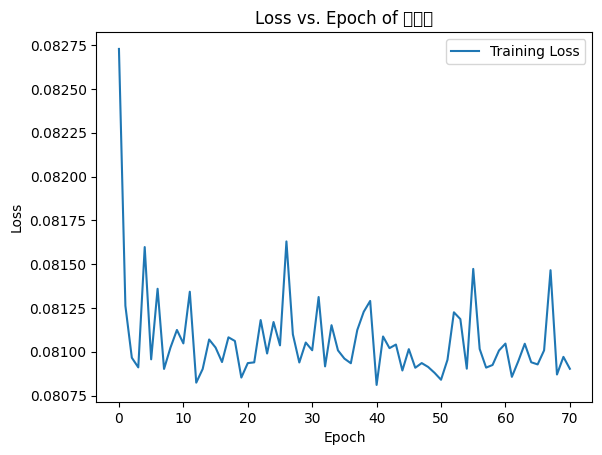

Processing medicine 32 of 102: 蒼朮
Training stopped at epoch 60
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33980 (\N{CJK UNIFIED IDEOGRAPH-84BC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26414 (\N{CJK UNIFIED IDEOGRAPH-672E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


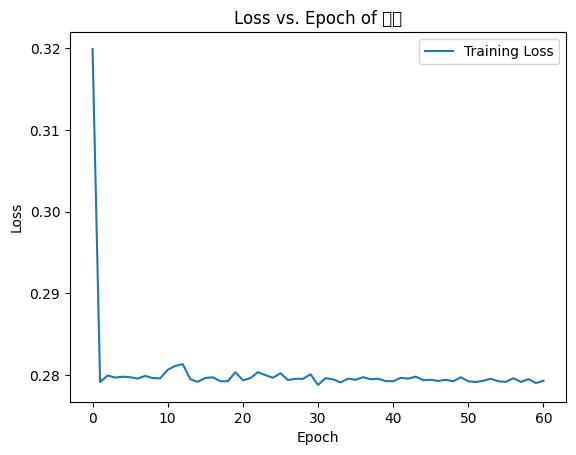

Processing medicine 33 of 102: 草果
Training stopped at epoch 46
5/5 [==============================] - 0s 1000us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


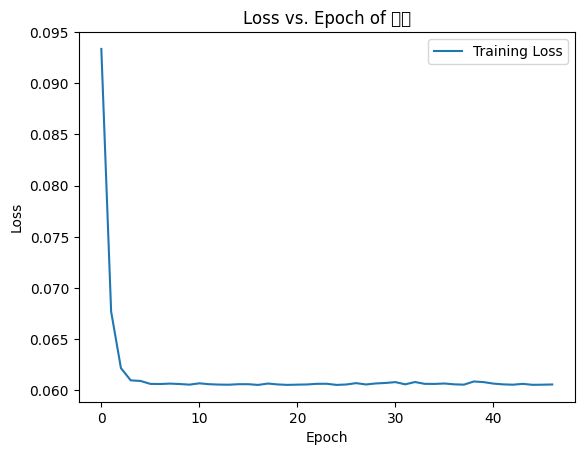

Processing medicine 34 of 102: 茯苓
Training stopped at epoch 557
5/5 [==============================] - 0s 3ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33583 (\N{CJK UNIFIED IDEOGRAPH-832F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33491 (\N{CJK UNIFIED IDEOGRAPH-82D3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


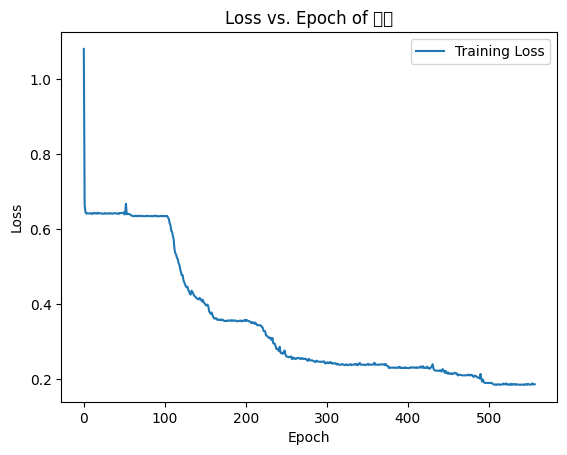

Processing medicine 35 of 102: 豬苓
Training stopped at epoch 72
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35948 (\N{CJK UNIFIED IDEOGRAPH-8C6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


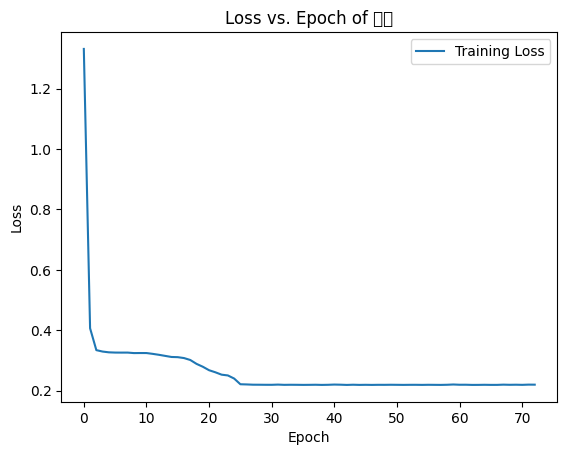

Processing medicine 36 of 102: 薏苡仁
Training stopped at epoch 42
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34191 (\N{CJK UNIFIED IDEOGRAPH-858F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33505 (\N{CJK UNIFIED IDEOGRAPH-82E1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


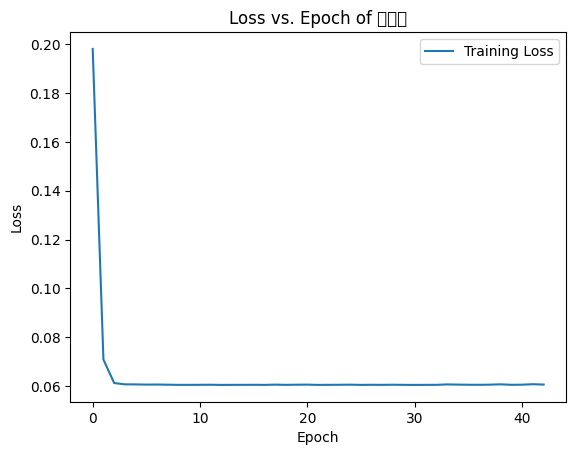

Processing medicine 37 of 102: 海金砂
Training stopped at epoch 46
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30722 (\N{CJK UNIFIED IDEOGRAPH-7802}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


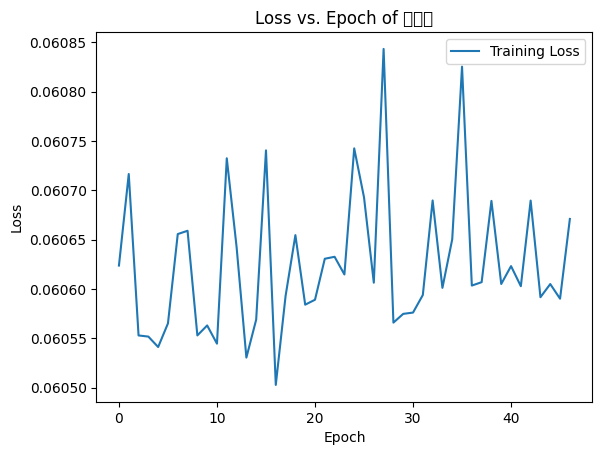

Processing medicine 38 of 102: 澤瀉
Training stopped at epoch 40
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28580 (\N{CJK UNIFIED IDEOGRAPH-6FA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28681 (\N{CJK UNIFIED IDEOGRAPH-7009}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


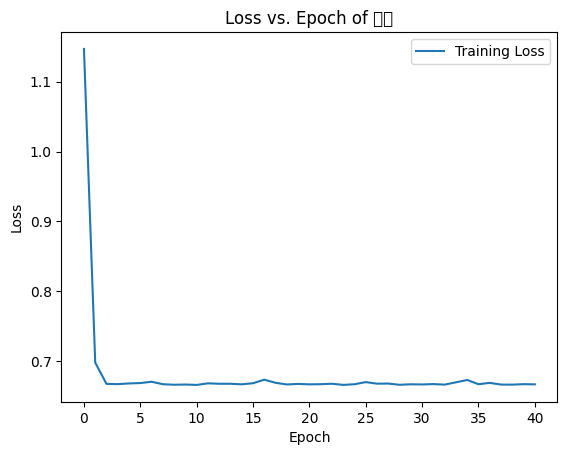

Processing medicine 39 of 102: 車前子
Training stopped at epoch 60
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36554 (\N{CJK UNIFIED IDEOGRAPH-8ECA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


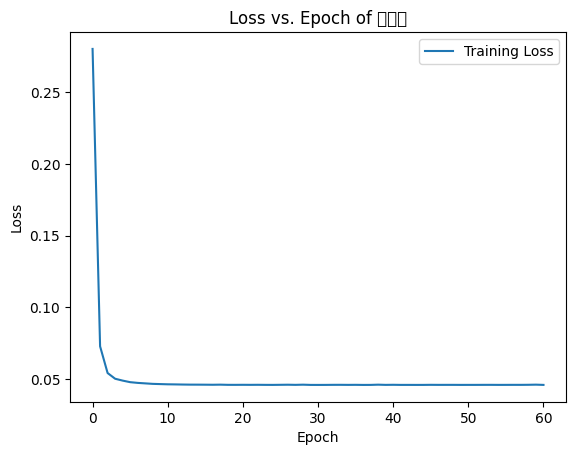

Processing medicine 40 of 102: 滑石
Training stopped at epoch 82
5/5 [==============================] - 0s 752us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


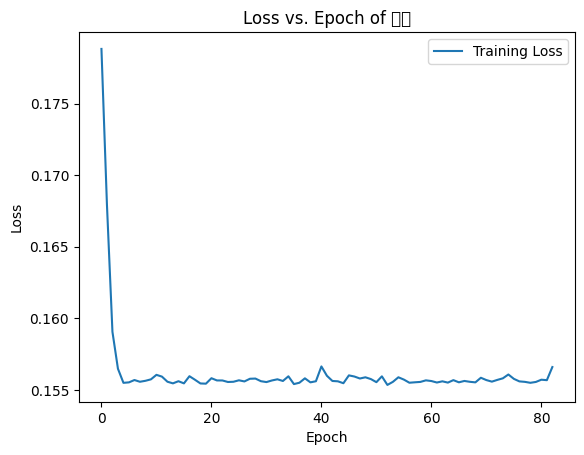

Processing medicine 41 of 102: 木通
Training stopped at epoch 53
5/5 [==============================] - 0s 1000us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26408 (\N{CJK UNIFIED IDEOGRAPH-6728}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


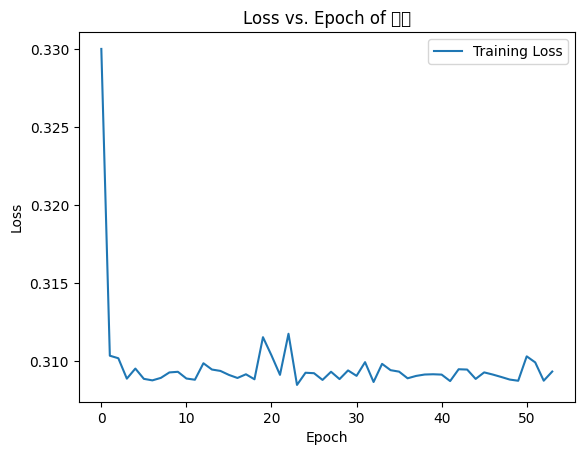

Processing medicine 42 of 102: 通草
Training stopped at epoch 57
5/5 [==============================] - 0s 1ms/step


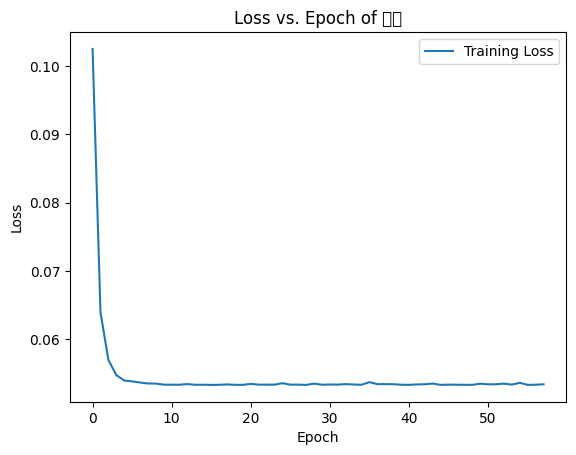

Processing medicine 43 of 102: 赤小豆
Training stopped at epoch 60
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36196 (\N{CJK UNIFIED IDEOGRAPH-8D64}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35910 (\N{CJK UNIFIED IDEOGRAPH-8C46}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


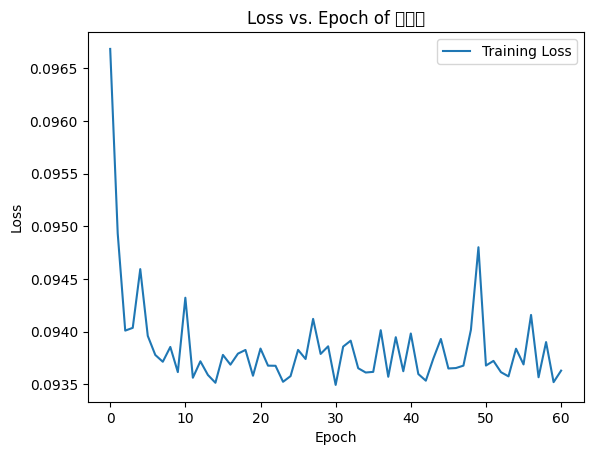

Processing medicine 44 of 102: 燈心草
Training stopped at epoch 45
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29128 (\N{CJK UNIFIED IDEOGRAPH-71C8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


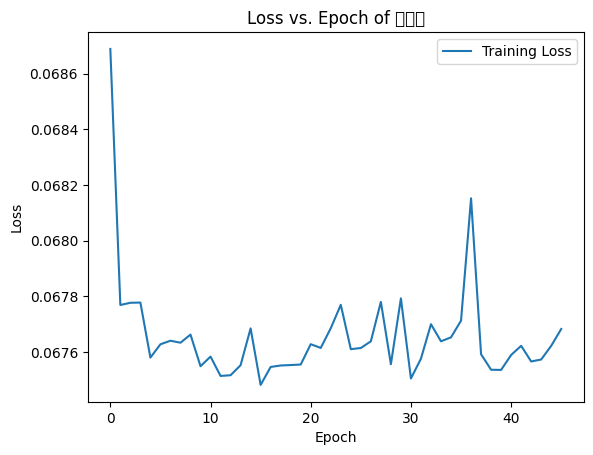

Processing medicine 45 of 102: 乾薑
Training stopped at epoch 106
5/5 [==============================] - 0s 750us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20094 (\N{CJK UNIFIED IDEOGRAPH-4E7E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


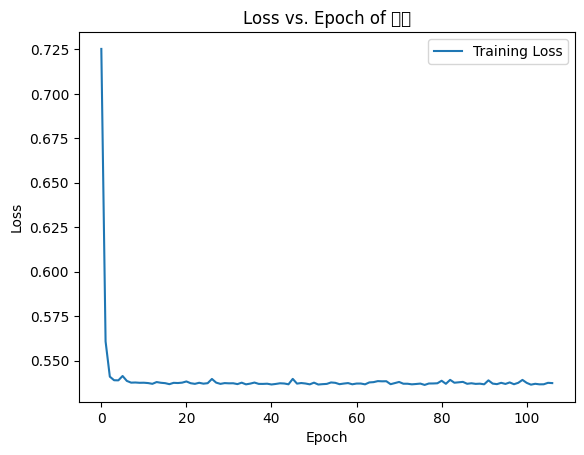

Processing medicine 46 of 102: 附子
Training stopped at epoch 137
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38468 (\N{CJK UNIFIED IDEOGRAPH-9644}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


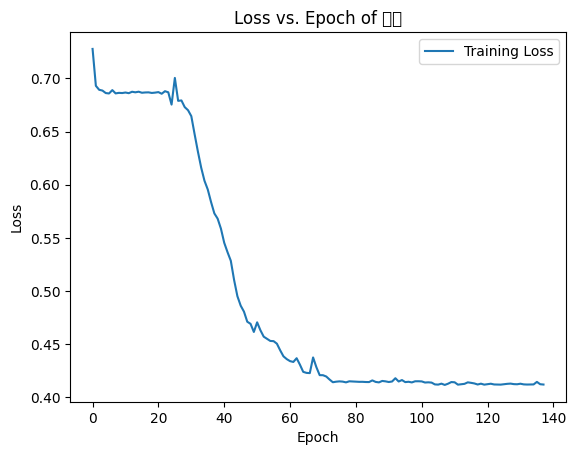

Processing medicine 47 of 102: 吳茱萸
Training stopped at epoch 33
5/5 [==============================] - 0s 752us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21555 (\N{CJK UNIFIED IDEOGRAPH-5433}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33585 (\N{CJK UNIFIED IDEOGRAPH-8331}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33848 (\N{CJK UNIFIED IDEOGRAPH-8438}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


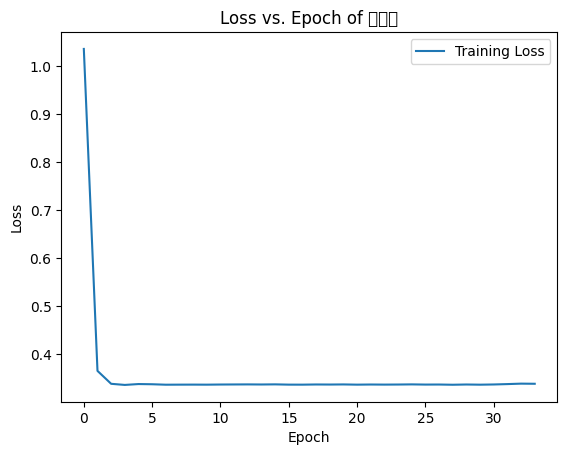

Processing medicine 48 of 102: 枳實
Training stopped at epoch 83
5/5 [==============================] - 0s 636us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26547 (\N{CJK UNIFIED IDEOGRAPH-67B3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


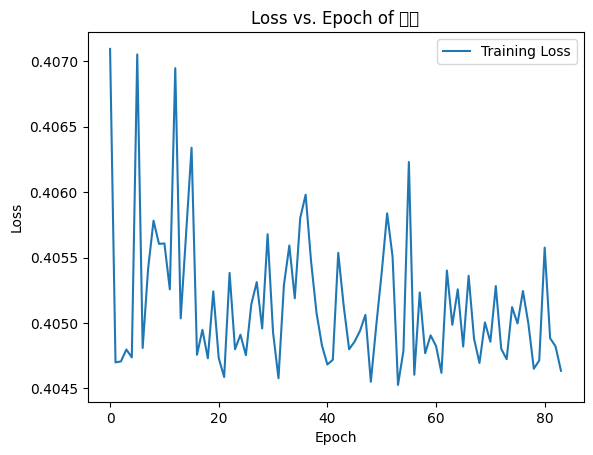

Processing medicine 49 of 102: 烏藥
Training stopped at epoch 65
5/5 [==============================] - 0s 163us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28879 (\N{CJK UNIFIED IDEOGRAPH-70CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34277 (\N{CJK UNIFIED IDEOGRAPH-85E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


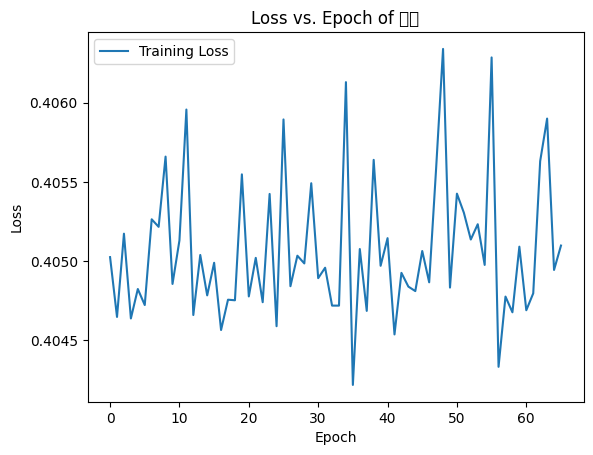

Processing medicine 50 of 102: 厚朴
Training stopped at epoch 58
5/5 [==============================] - 0s 716us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21402 (\N{CJK UNIFIED IDEOGRAPH-539A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26420 (\N{CJK UNIFIED IDEOGRAPH-6734}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


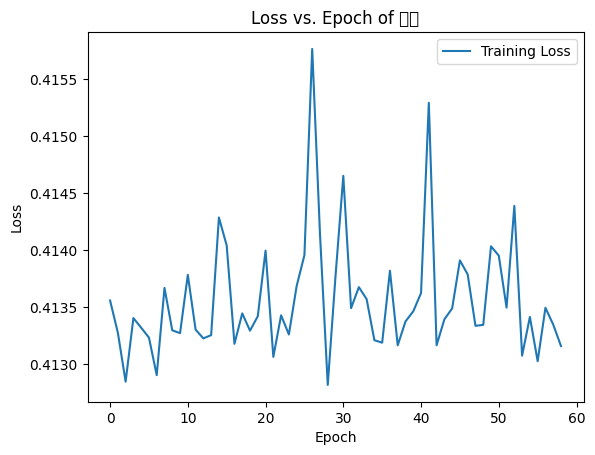

Processing medicine 51 of 102: 大腹皮
Training stopped at epoch 87
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33145 (\N{CJK UNIFIED IDEOGRAPH-8179}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


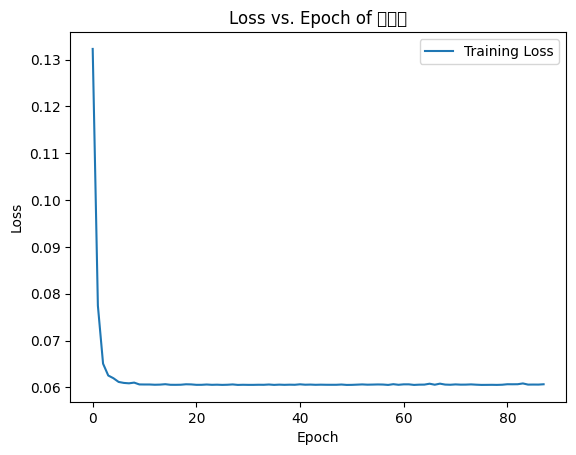

Processing medicine 52 of 102: 青皮
Training stopped at epoch 48
5/5 [==============================] - 0s 313us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


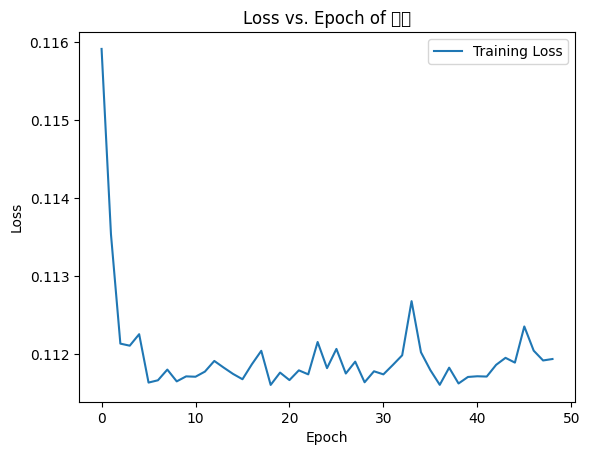

Processing medicine 53 of 102: 薤白
Training stopped at epoch 42
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34212 (\N{CJK UNIFIED IDEOGRAPH-85A4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


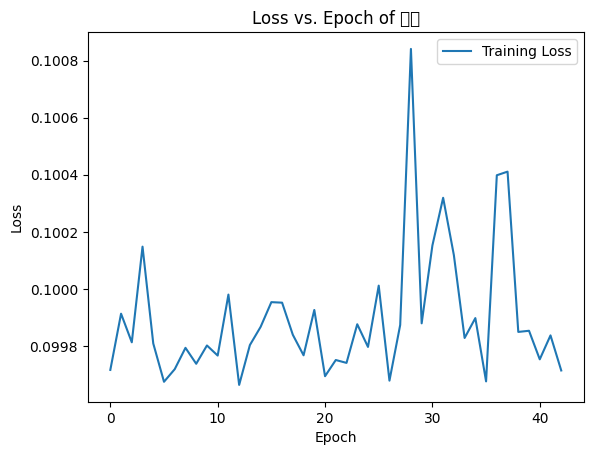

Processing medicine 54 of 102: 麥芽
Training stopped at epoch 72
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40613 (\N{CJK UNIFIED IDEOGRAPH-9EA5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33469 (\N{CJK UNIFIED IDEOGRAPH-82BD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


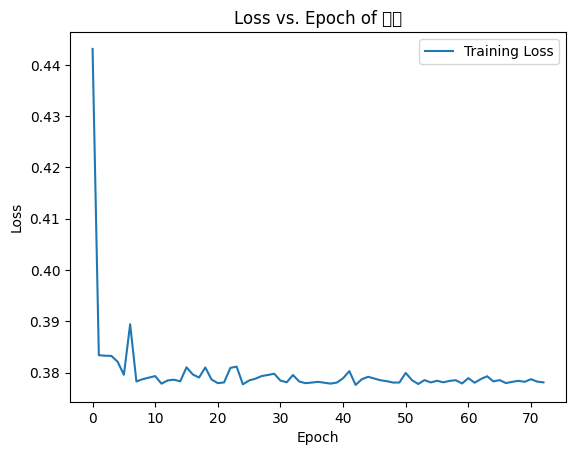

Processing medicine 55 of 102: 側柏葉
Training stopped at epoch 62
5/5 [==============================] - 0s 797us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20596 (\N{CJK UNIFIED IDEOGRAPH-5074}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33865 (\N{CJK UNIFIED IDEOGRAPH-8449}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


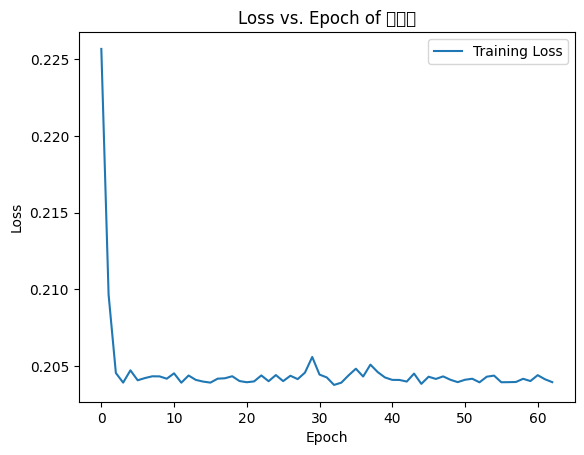

Processing medicine 56 of 102: 槐花
Training stopped at epoch 65
5/5 [==============================] - 0s 221us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27088 (\N{CJK UNIFIED IDEOGRAPH-69D0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


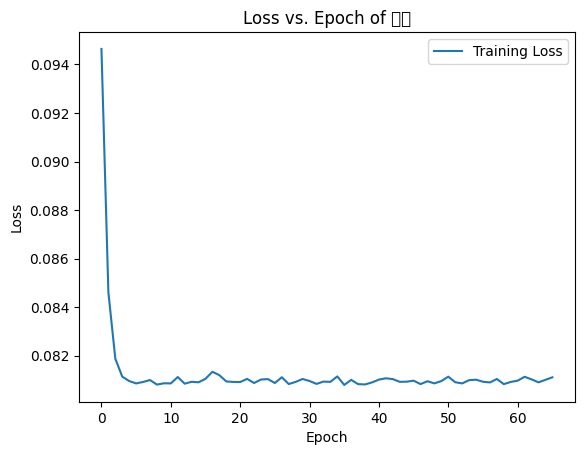

Processing medicine 57 of 102: 三七
Training stopped at epoch 41
5/5 [==============================] - 0s 416us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


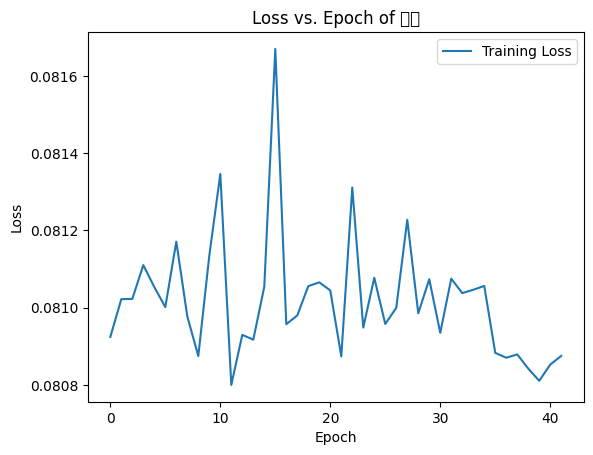

Processing medicine 58 of 102: 茜草
Training stopped at epoch 82
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33564 (\N{CJK UNIFIED IDEOGRAPH-831C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


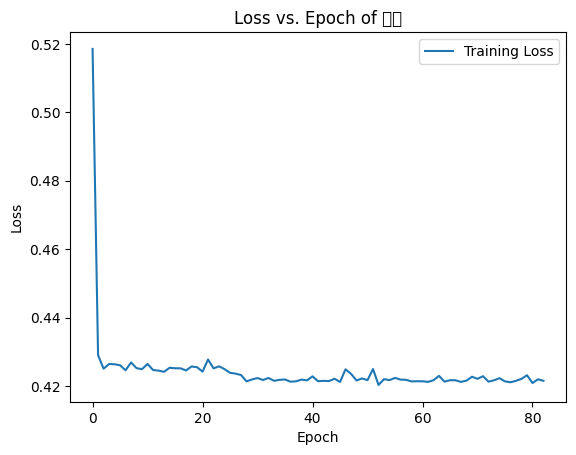

Processing medicine 59 of 102: 川芎
Training stopped at epoch 34
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24029 (\N{CJK UNIFIED IDEOGRAPH-5DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33422 (\N{CJK UNIFIED IDEOGRAPH-828E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


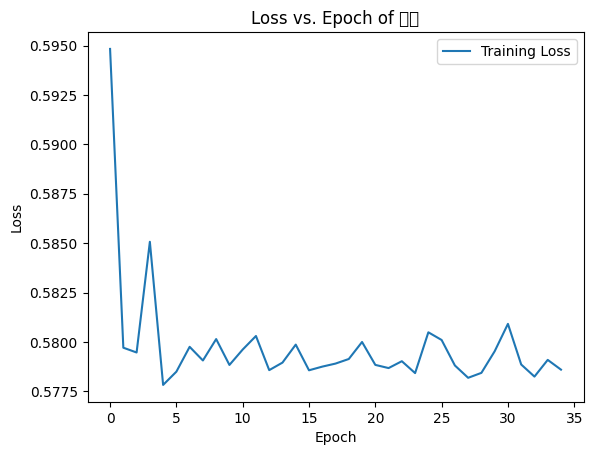

Processing medicine 60 of 102: 乳香
Training stopped at epoch 176
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20083 (\N{CJK UNIFIED IDEOGRAPH-4E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


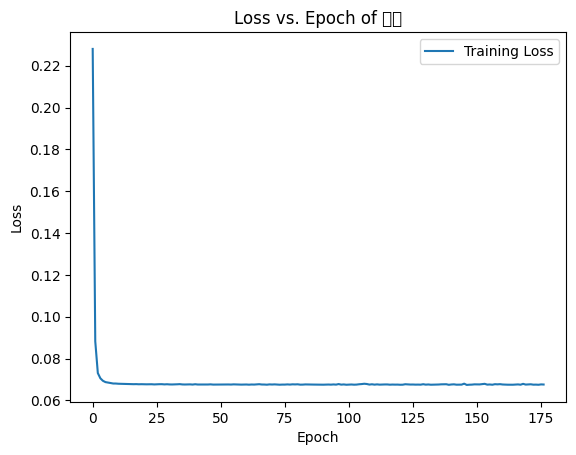

Processing medicine 61 of 102: 延胡索
Training stopped at epoch 67
5/5 [==============================] - 0s 751us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24310 (\N{CJK UNIFIED IDEOGRAPH-5EF6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


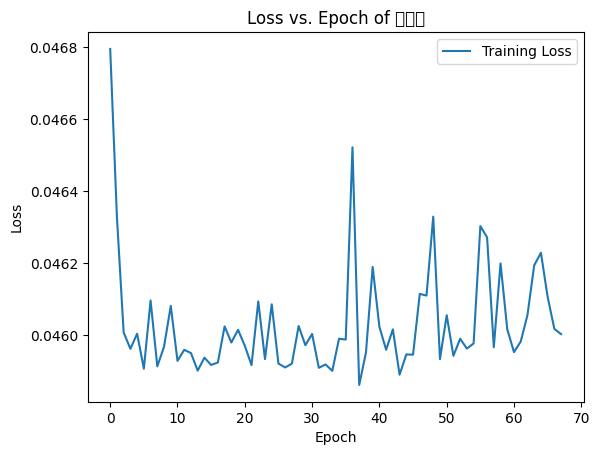

Processing medicine 62 of 102: 鬱金
Training stopped at epoch 103
5/5 [==============================] - 0s 650us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39729 (\N{CJK UNIFIED IDEOGRAPH-9B31}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


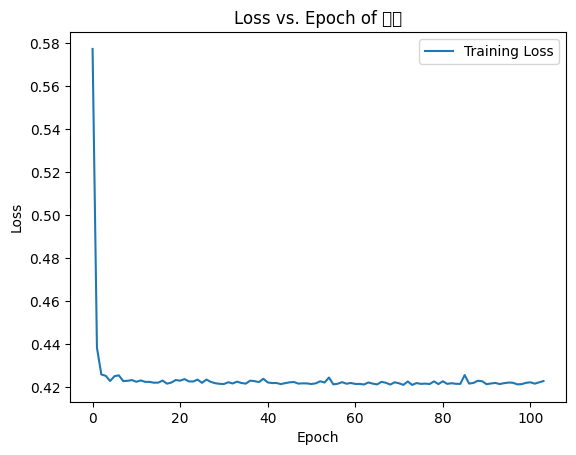

Processing medicine 63 of 102: 紅花
Training stopped at epoch 158
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32005 (\N{CJK UNIFIED IDEOGRAPH-7D05}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


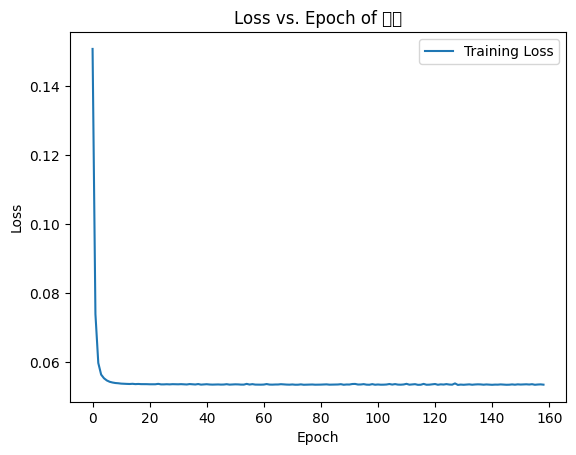

Processing medicine 64 of 102: 桃仁
Training stopped at epoch 53
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26691 (\N{CJK UNIFIED IDEOGRAPH-6843}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


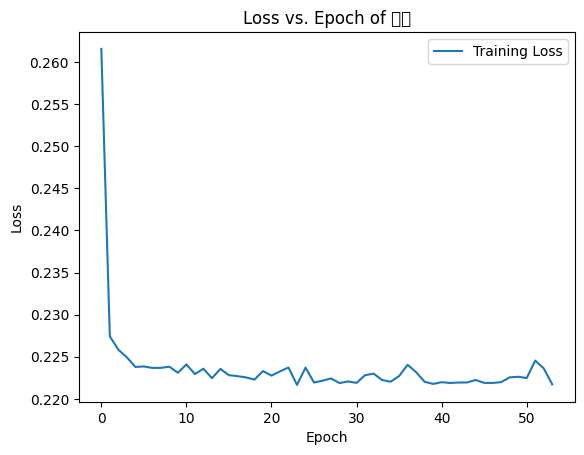

Processing medicine 65 of 102: 牛膝
Training stopped at epoch 102
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29275 (\N{CJK UNIFIED IDEOGRAPH-725B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33181 (\N{CJK UNIFIED IDEOGRAPH-819D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


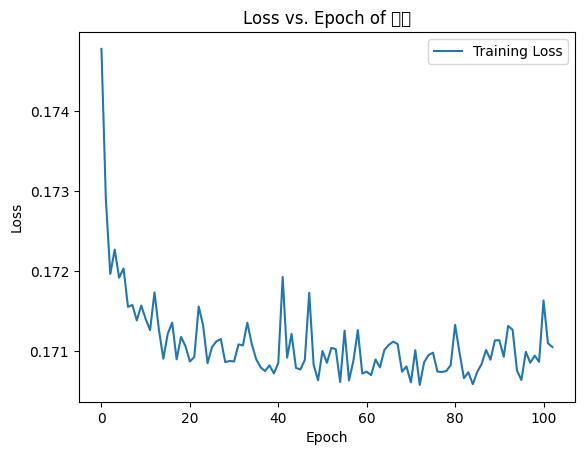

Processing medicine 66 of 102: 半夏
Training stopped at epoch 71
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21322 (\N{CJK UNIFIED IDEOGRAPH-534A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


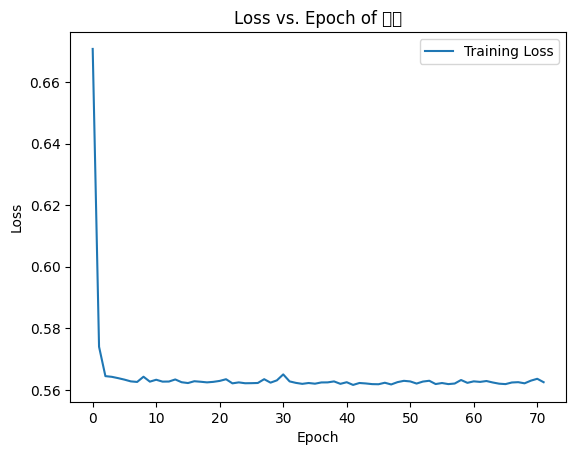

Processing medicine 67 of 102: 白附子
Training stopped at epoch 49
5/5 [==============================] - 0s 251us/step


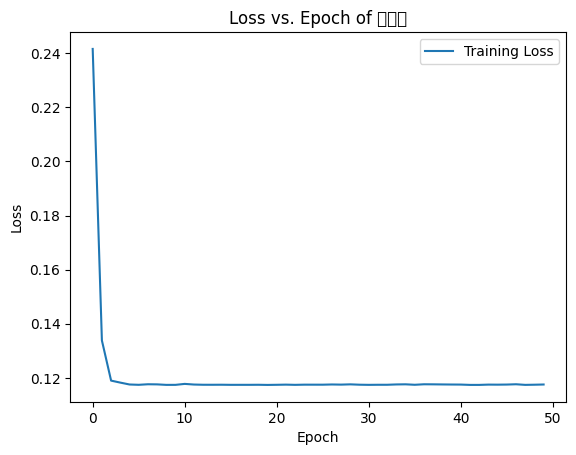

Processing medicine 68 of 102: 桔梗
Training stopped at epoch 33
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26708 (\N{CJK UNIFIED IDEOGRAPH-6854}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26775 (\N{CJK UNIFIED IDEOGRAPH-6897}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


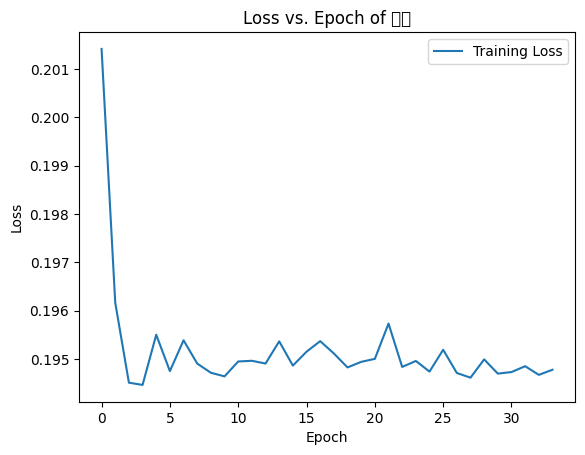

Processing medicine 69 of 102: 旋覆花
Training stopped at epoch 40
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35206 (\N{CJK UNIFIED IDEOGRAPH-8986}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


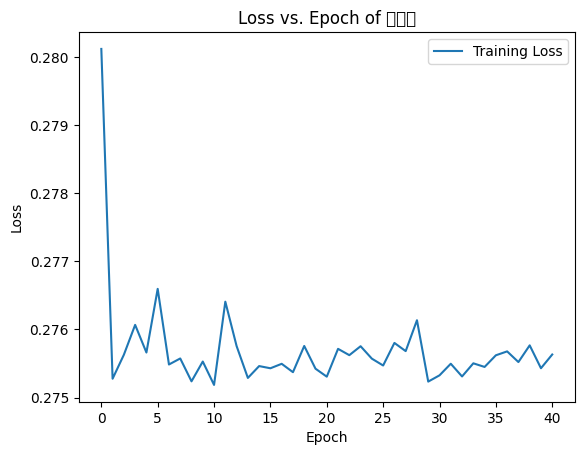

Processing medicine 70 of 102: 瓜蔞
Training stopped at epoch 40
5/5 [==============================] - 0s 660us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29916 (\N{CJK UNIFIED IDEOGRAPH-74DC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34078 (\N{CJK UNIFIED IDEOGRAPH-851E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


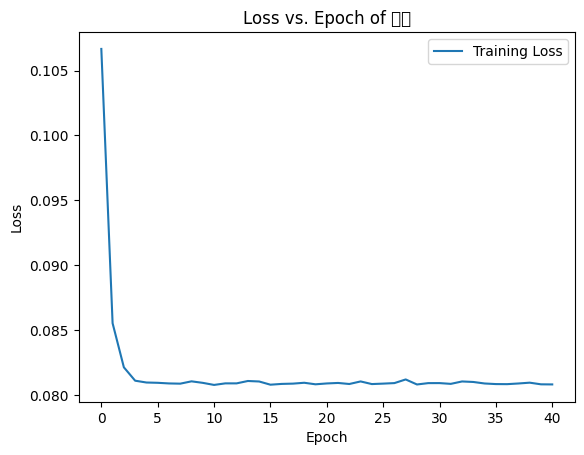

Processing medicine 71 of 102: 海藻
Training stopped at epoch 47
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


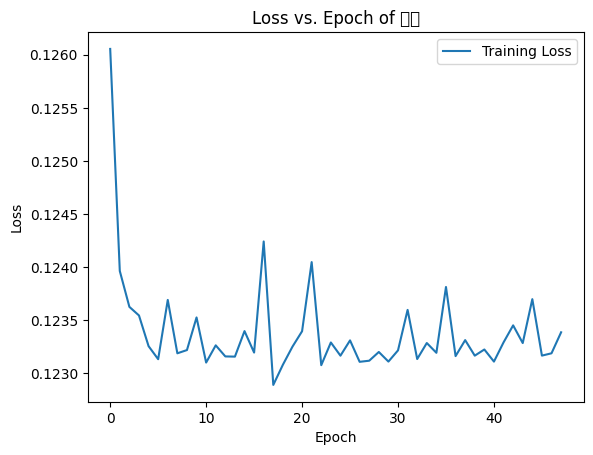

Processing medicine 72 of 102: 杏仁
Training stopped at epoch 139
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26447 (\N{CJK UNIFIED IDEOGRAPH-674F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


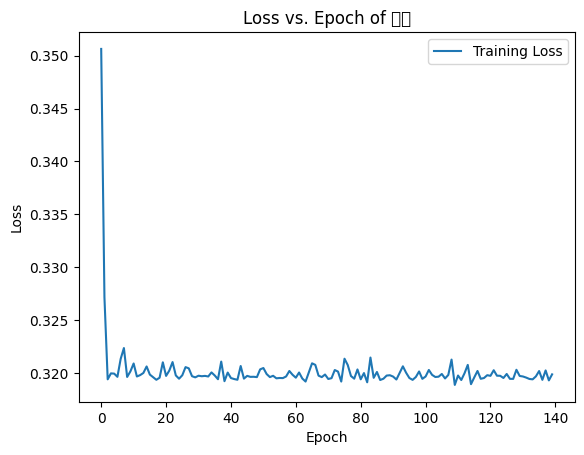

Processing medicine 73 of 102: 紫菀
Training stopped at epoch 51
5/5 [==============================] - 0s 454us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32043 (\N{CJK UNIFIED IDEOGRAPH-7D2B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33728 (\N{CJK UNIFIED IDEOGRAPH-83C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


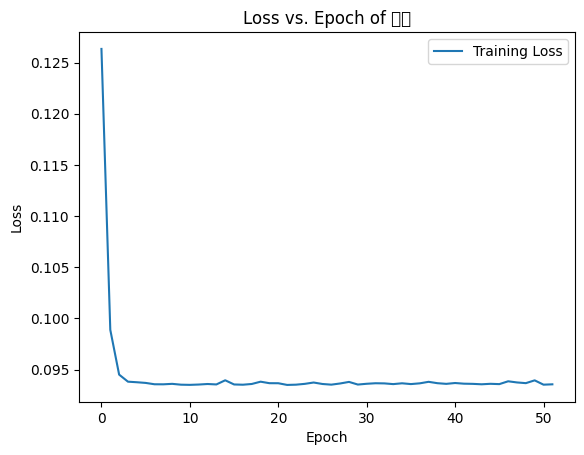

Processing medicine 74 of 102: 龍骨
Training stopped at epoch 51
5/5 [==============================] - 0s 929us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39592 (\N{CJK UNIFIED IDEOGRAPH-9AA8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


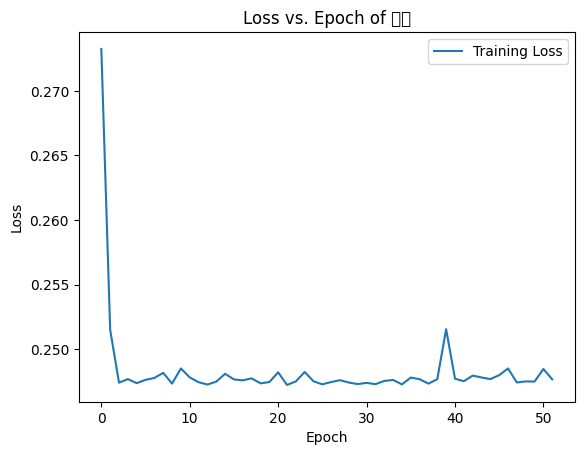

Processing medicine 75 of 102: 牡蠣
Training stopped at epoch 54
5/5 [==============================] - 0s 201us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 34851 (\N{CJK UNIFIED IDEOGRAPH-8823}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


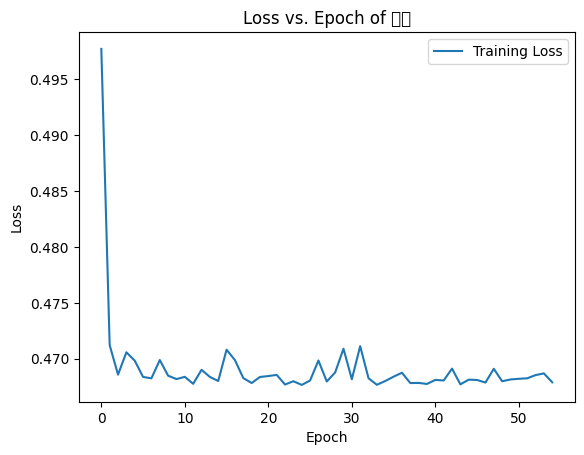

Processing medicine 76 of 102: 酸棗仁
Training stopped at epoch 65
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37240 (\N{CJK UNIFIED IDEOGRAPH-9178}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26839 (\N{CJK UNIFIED IDEOGRAPH-68D7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


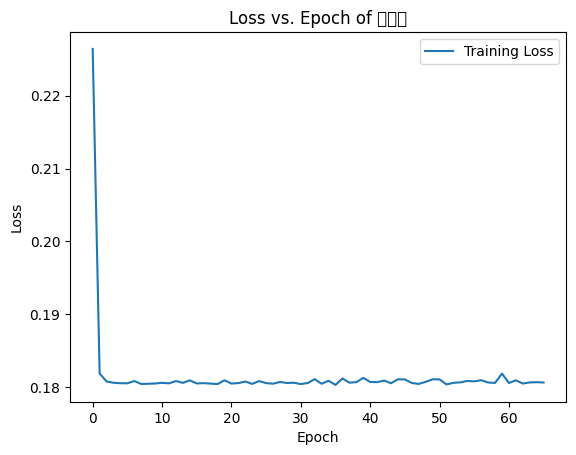

Processing medicine 77 of 102: 遠志
Training stopped at epoch 40
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36960 (\N{CJK UNIFIED IDEOGRAPH-9060}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24535 (\N{CJK UNIFIED IDEOGRAPH-5FD7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


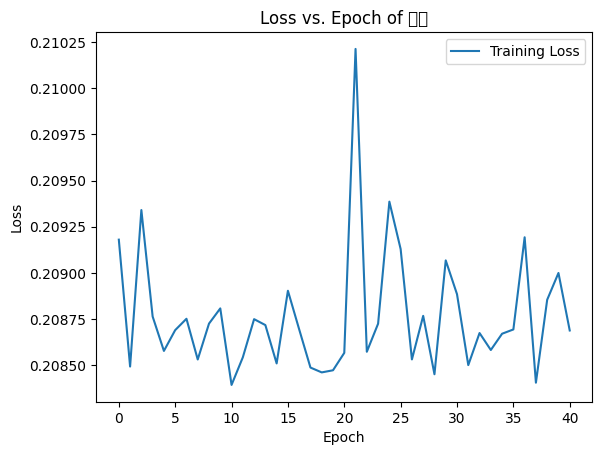

Processing medicine 78 of 102: 小麥
Training stopped at epoch 100
5/5 [==============================] - 0s 0s/step


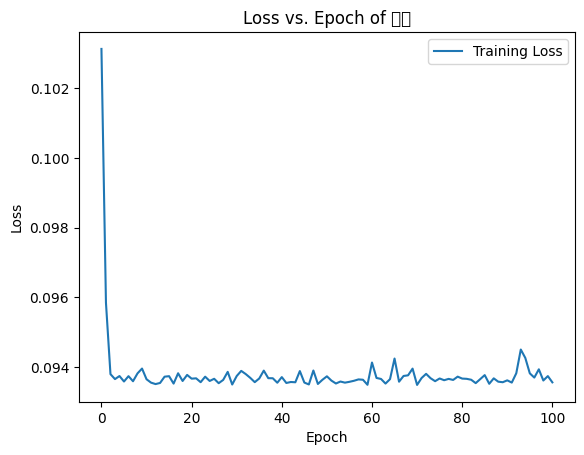

Processing medicine 79 of 102: 代赭石
Training stopped at epoch 43
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36205 (\N{CJK UNIFIED IDEOGRAPH-8D6D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


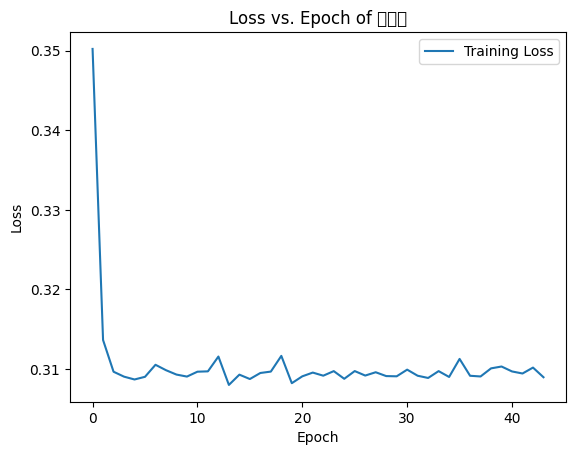

Processing medicine 80 of 102: 黃耆
Training stopped at epoch 31
5/5 [==============================] - 0s 953us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32774 (\N{CJK UNIFIED IDEOGRAPH-8006}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


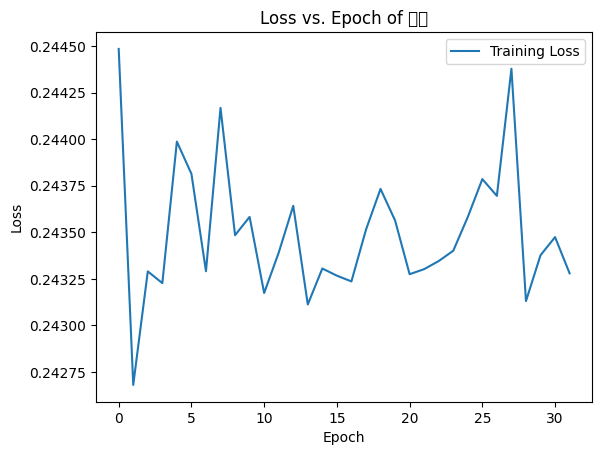

Processing medicine 81 of 102: 白朮
Training stopped at epoch 59
5/5 [==============================] - 0s 1ms/step


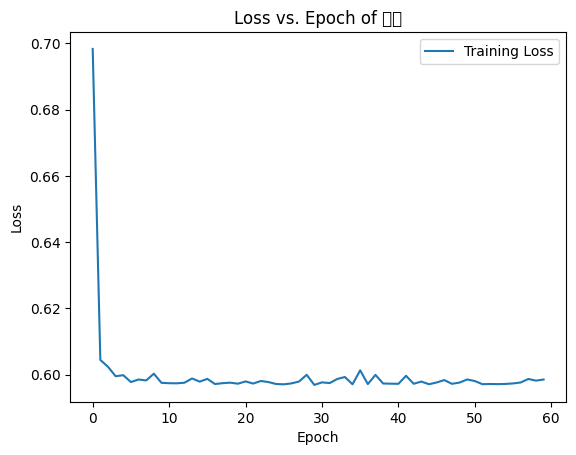

Processing medicine 82 of 102: 大棗
Training stopped at epoch 35
5/5 [==============================] - 0s 501us/step


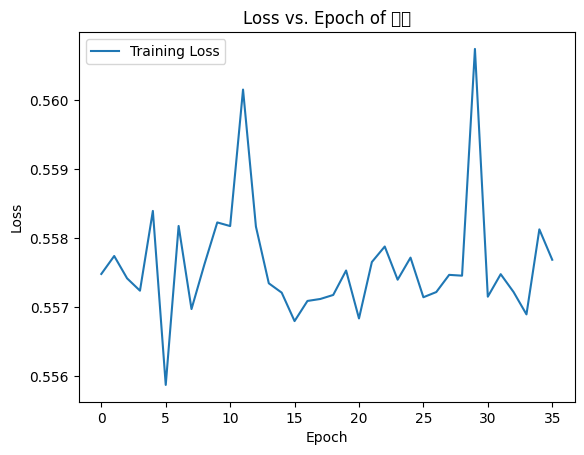

Processing medicine 83 of 102: 甘草
Training stopped at epoch 34
5/5 [==============================] - 0s 362us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29976 (\N{CJK UNIFIED IDEOGRAPH-7518}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


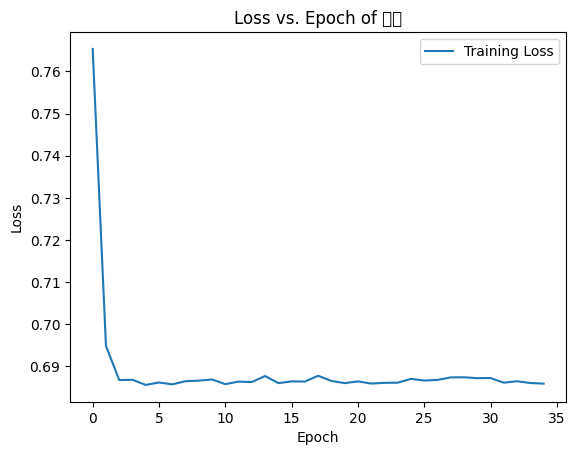

Processing medicine 84 of 102: 巴戟天
Training stopped at epoch 70
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25119 (\N{CJK UNIFIED IDEOGRAPH-621F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


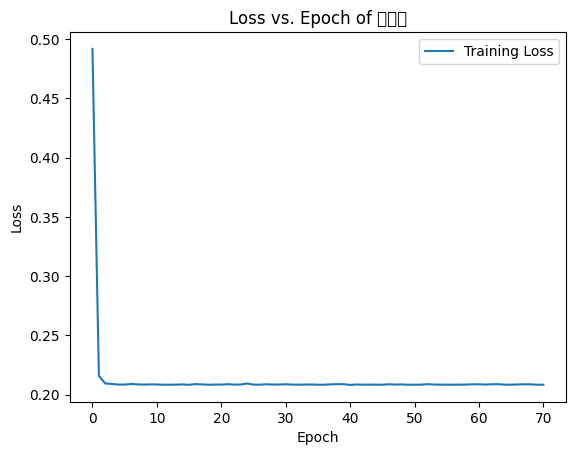

Processing medicine 85 of 102: 補骨脂
Training stopped at epoch 88
5/5 [==============================] - 0s 732us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35036 (\N{CJK UNIFIED IDEOGRAPH-88DC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33026 (\N{CJK UNIFIED IDEOGRAPH-8102}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


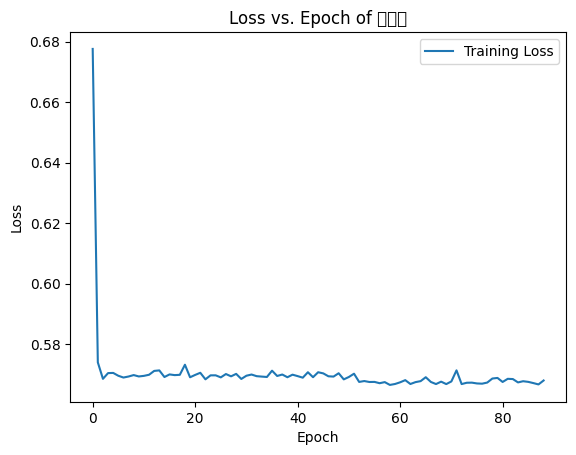

Processing medicine 86 of 102: 益智仁
Training stopped at epoch 112
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


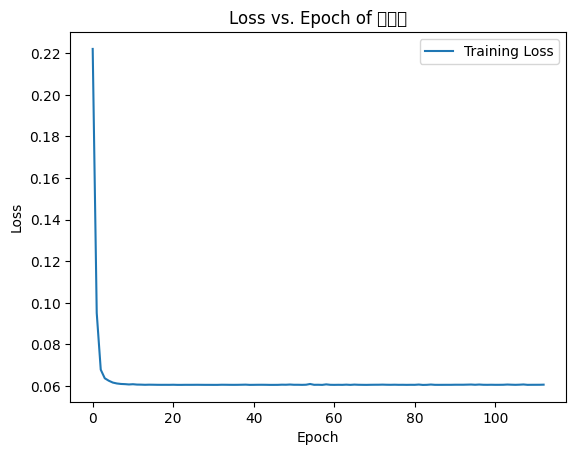

Processing medicine 87 of 102: 陽起石
Training stopped at epoch 40
5/5 [==============================] - 0s 1000us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38525 (\N{CJK UNIFIED IDEOGRAPH-967D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36215 (\N{CJK UNIFIED IDEOGRAPH-8D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


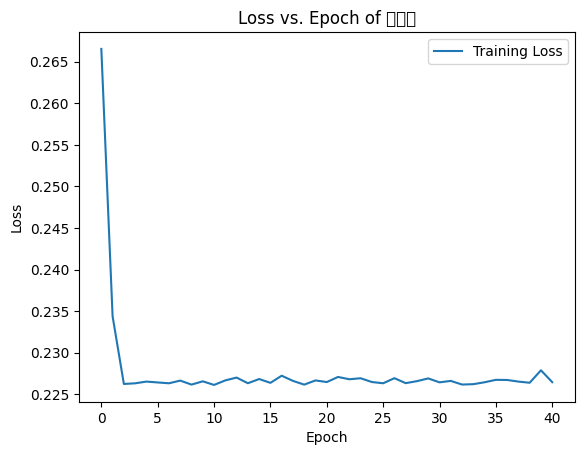

Processing medicine 88 of 102: 續斷
Training stopped at epoch 33
5/5 [==============================] - 0s 502us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32396 (\N{CJK UNIFIED IDEOGRAPH-7E8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26039 (\N{CJK UNIFIED IDEOGRAPH-65B7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


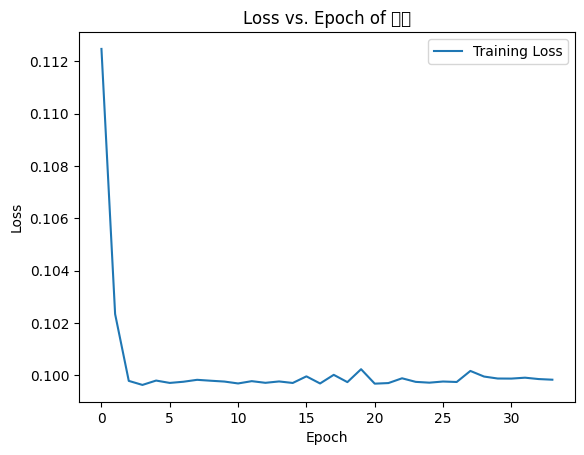

Processing medicine 89 of 102: 杜仲
Training stopped at epoch 66
5/5 [==============================] - 0s 761us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26460 (\N{CJK UNIFIED IDEOGRAPH-675C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20210 (\N{CJK UNIFIED IDEOGRAPH-4EF2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


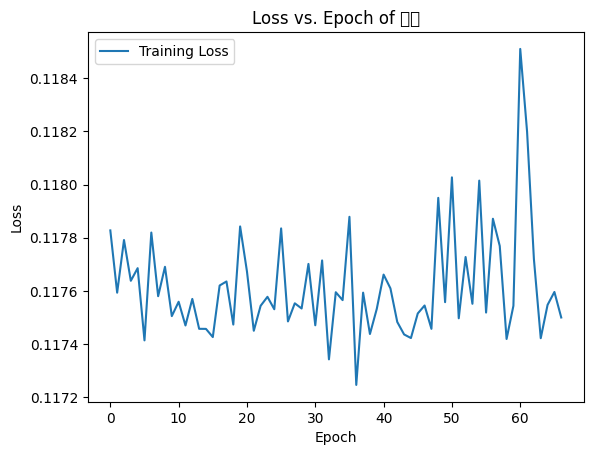

Processing medicine 90 of 102: 何首烏
Training stopped at epoch 80
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20309 (\N{CJK UNIFIED IDEOGRAPH-4F55}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


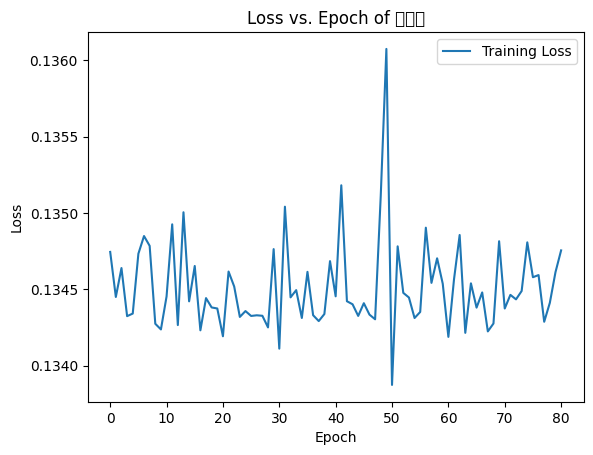

Processing medicine 91 of 102: 當歸
Training stopped at epoch 162
5/5 [==============================] - 0s 860us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30070 (\N{CJK UNIFIED IDEOGRAPH-7576}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27512 (\N{CJK UNIFIED IDEOGRAPH-6B78}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


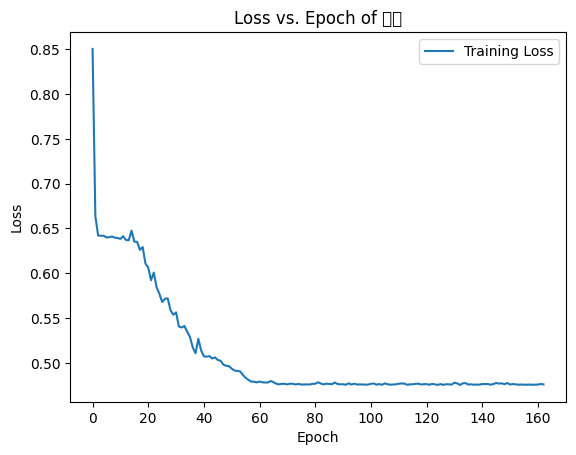

Processing medicine 92 of 102: 白芍
Training stopped at epoch 70
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33421 (\N{CJK UNIFIED IDEOGRAPH-828D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


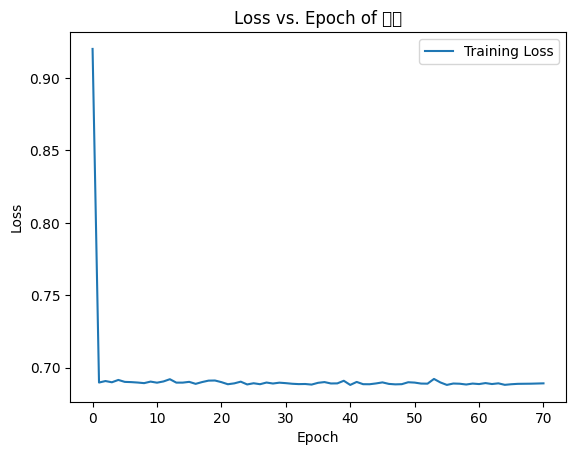

Processing medicine 93 of 102: 阿膠
Training stopped at epoch 31
5/5 [==============================] - 0s 768us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38463 (\N{CJK UNIFIED IDEOGRAPH-963F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33184 (\N{CJK UNIFIED IDEOGRAPH-81A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


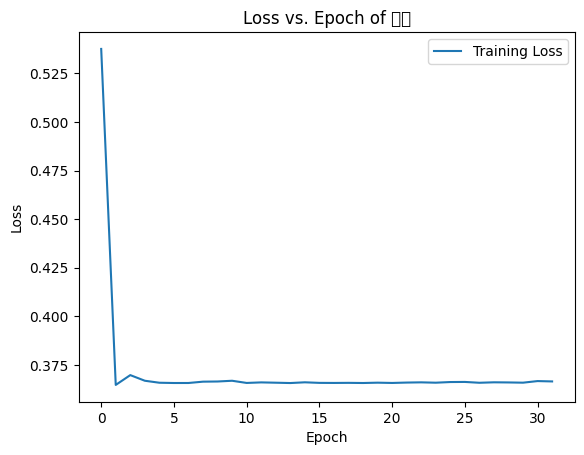

Processing medicine 94 of 102: 西洋參
Training stopped at epoch 74
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27915 (\N{CJK UNIFIED IDEOGRAPH-6D0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21443 (\N{CJK UNIFIED IDEOGRAPH-53C3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


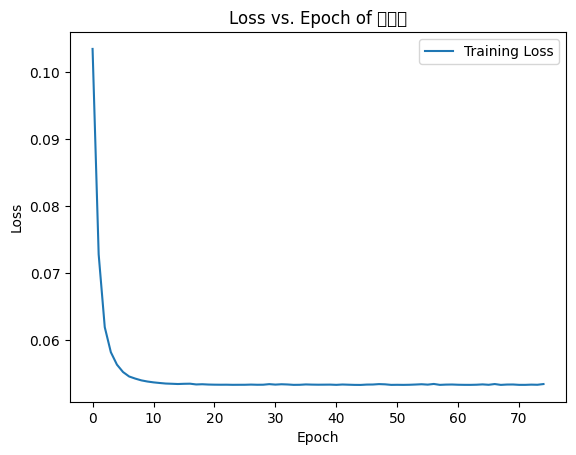

Processing medicine 95 of 102: 龜板
Training stopped at epoch 47
5/5 [==============================] - 0s 755us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40860 (\N{CJK UNIFIED IDEOGRAPH-9F9C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26495 (\N{CJK UNIFIED IDEOGRAPH-677F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


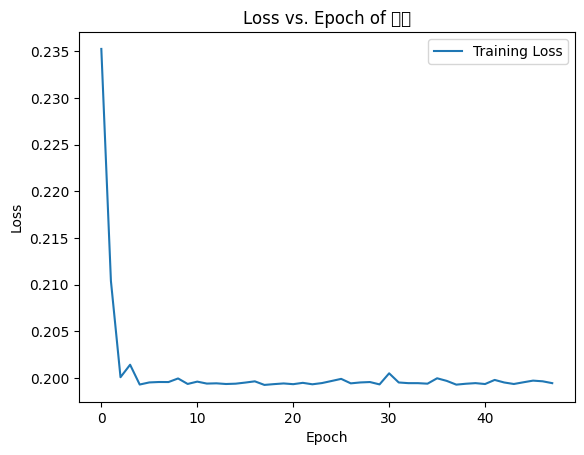

Processing medicine 96 of 102: 鱉甲
Training stopped at epoch 53
5/5 [==============================] - 0s 751us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 40009 (\N{CJK UNIFIED IDEOGRAPH-9C49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30002 (\N{CJK UNIFIED IDEOGRAPH-7532}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


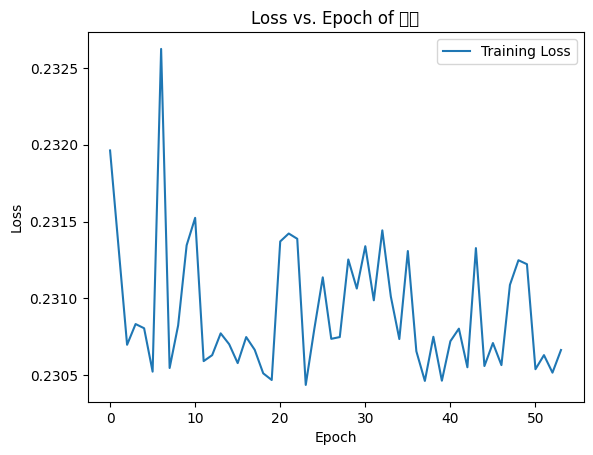

Processing medicine 97 of 102: 山茱萸
Training stopped at epoch 33
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


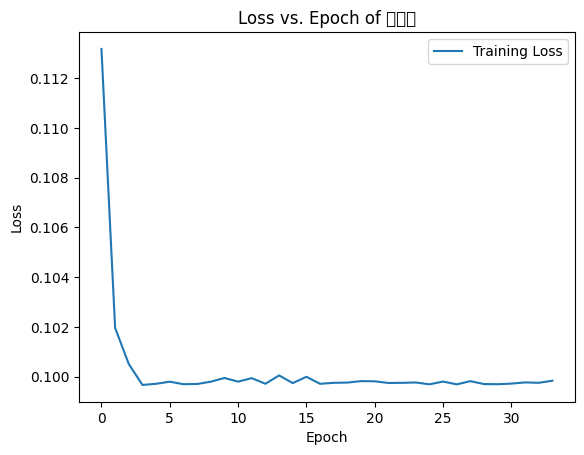

Processing medicine 98 of 102: 覆盆子
Training stopped at epoch 53
5/5 [==============================] - 0s 0s/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30406 (\N{CJK UNIFIED IDEOGRAPH-76C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


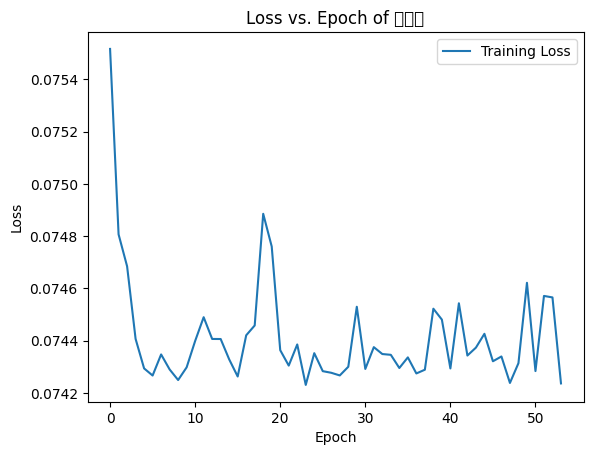

Processing medicine 99 of 102: 五味子
Training stopped at epoch 62
5/5 [==============================] - 0s 2ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21619 (\N{CJK UNIFIED IDEOGRAPH-5473}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


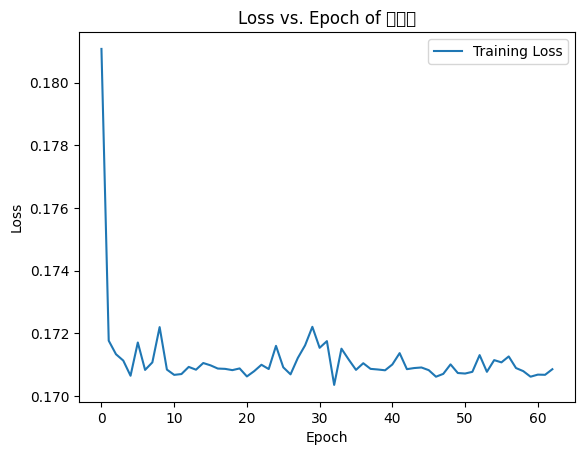

Processing medicine 100 of 102: 烏梅
Training stopped at epoch 46
5/5 [==============================] - 0s 1ms/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26757 (\N{CJK UNIFIED IDEOGRAPH-6885}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


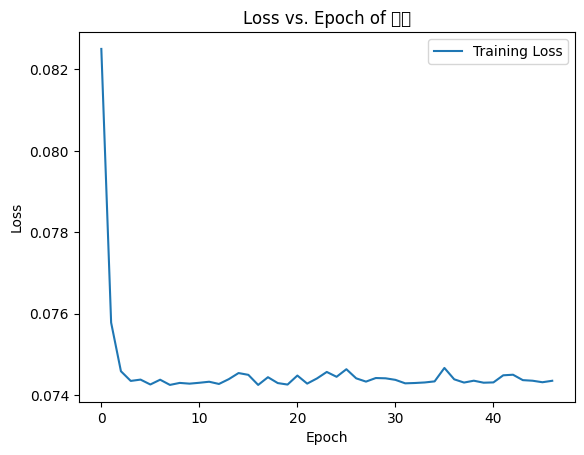

Processing medicine 101 of 102: 五倍子
Training stopped at epoch 40
5/5 [==============================] - 0s 756us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20493 (\N{CJK UNIFIED IDEOGRAPH-500D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


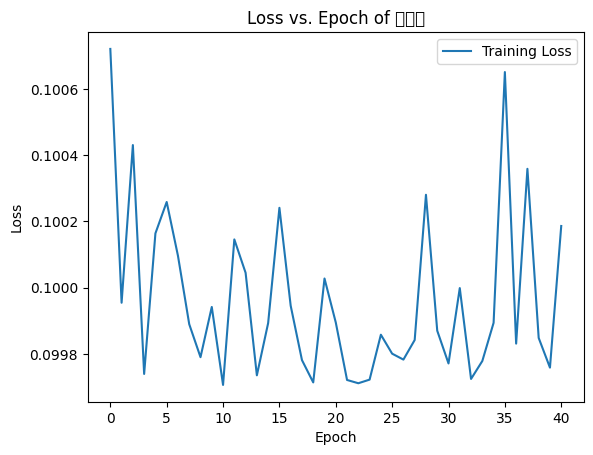

Processing medicine 102 of 102: 炙甘草
Training stopped at epoch 35
5/5 [==============================] - 0s 749us/step


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28825 (\N{CJK UNIFIED IDEOGRAPH-7099}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


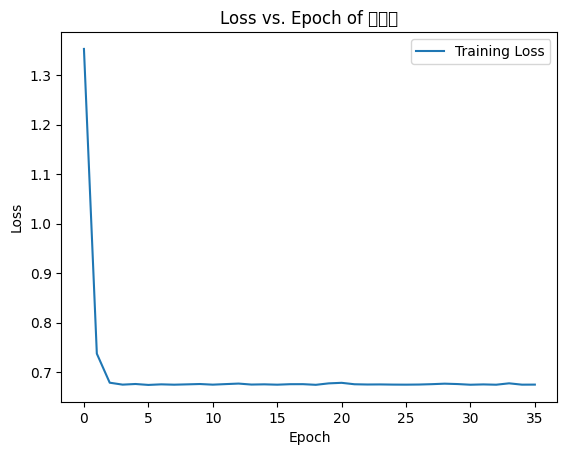

Training done.


<Figure size 640x480 with 0 Axes>

In [7]:

# Initialize dictionaries to store results and training history
result_df_dict = {}        # Dictionary of DataFrames of each medicine in training set 
accuracy_dict = {}         # Dictionary of accuracy for each medicine
prediction_train_dict = {}  # Dictionary of raw predictions for the training set
prediction_val_dict = {}    # Dictionary of raw predictions for the validation set

# Iterate over each medicine
for i in range(train_y.shape[1]):
    chosen_col = train_y.iloc[:, i].copy()
    
    # Ensure that the chosen column is a pandas Series
    assert(isinstance(chosen_col, pd.Series))
    assert(len(chosen_col) == len(train_y))
    
    print(f"Processing medicine {i + 1} of {train_y.shape[1]}: {chosen_col.name}")

    # Convert the chosen column to NumPy array
    chosen_y_np = chosen_col.values.astype('float64')

    # Copy the corresponding validation set column
    y_val_chosen_col = val_y.iloc[:, i].copy()
    
    # Ensure that the validation set column is a pandas Series
    assert(isinstance(y_val_chosen_col, pd.Series))
    assert(len(y_val_chosen_col) == len(val_y))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

    # Fit the model for the current medicine
    Model = model.fit(
        x=X_np,
        y=chosen_y_np,
        class_weight=class_weight_dic[i] if UseClassWeight else None,
        epochs=5000,
        shuffle=True,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Print when training stopped
    print(f"Training stopped at epoch {Model.epoch[-1]}")
    
    # Predict against the training set for diagnosing overfitting or underfitting
    predictions_train_set = model.predict(X_np)
    
    # Save raw result numpy array of training set to the dictionary
    prediction_train_dict[chosen_col.name] = predictions_train_set
    
    # Make predictions for the validation set
    predictions_val_set = model.predict(X_val_np)
    
    # Save raw result numpy array of validation set to the dictionary
    prediction_val_dict[chosen_col.name] = predictions_val_set
    
    # Plotting loss vs. epoch
    plt.plot(Model.history['loss'], label='Training Loss')
    plt.title(f'Loss vs. Epoch of {chosen_col.name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    figure_save_path = myutil.get_figure_save_path(f"{chosen_col.name}_epoch_loss")
    plt.savefig(figure_save_path)

print("Training done.")


# 7. Handle result

### 7.1 Calculate the f1 score of the training dataset and store the values in TrainMedicineDictioanry

In [8]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for the training set
total_tp_train = 0
total_fp_train = 0
total_tn_train = 0
total_fn_train = 0

# Create a dictioanry to store all values of a medicine
TrainMedicineDictioanry = {}

# Iterate through each medicine's raw prediction array
for key, arr in prediction_train_dict.items():
    
    # Create a DataFrame from the raw prediction array
    df_tmp = pd.DataFrame(arr, columns=["predicted as 0", "predicted as 1"])

    # Determine the predicted value based on probabilities
    df_tmp["predicted value"] = np.where(df_tmp["predicted as 0"] > df_tmp["predicted as 1"], 0, 1)
    
    # Get the column number of the current medicine in the training labels
    col_num = train_y.columns.get_loc(key)
    
    # Add ground truth values to the DataFrame
    df_tmp["ground truth"] = train_y.iloc[:, col_num].copy().values
    
    
    TP = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 1)).sum()
    FP = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 1)).sum()
    FN = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 0)).sum()
    TN = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 0)).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate TP, FP, FN, TN for the current medicine
    total_tp_train += TP
    total_fp_train += FP
    total_fn_train += FN
    total_tn_train += TN
    
    TrainMedicineDictioanry[key] = {
        "TP" : TP,
        "FP" : FP,
        "FN" : FN,
        "TN" : TN,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1score
    }

precision = total_tp_train / (total_tp_train + total_fp_train)
recall = total_tp_train / (total_tp_train + total_fn_train)

TrainMedicineDictioanry["overall"] = {
        "TP" : total_tp_train,
        "FP" : total_fp_train,
        "FN" : total_fn_train,
        "TN" : total_tn_train,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
}

print("TrainMedicineDictioanry:")
for key in TrainMedicineDictioanry:
    print(key, TrainMedicineDictioanry[key])

TrainMedicineDictioanry:
麻黃 {'TP': 95, 'FP': 4, 'FN': 2, 'TN': 536, 'precision': 0.9595959595959596, 'recall': 0.979381443298969, 'f1-score': 0.9693877551020409}
桂枝 {'TP': 264, 'FP': 0, 'FN': 10, 'TN': 363, 'precision': 1.0, 'recall': 0.9635036496350365, 'f1-score': 0.9814126394052044}
荊芥 {'TP': 15, 'FP': 1, 'FN': 0, 'TN': 621, 'precision': 0.9375, 'recall': 1.0, 'f1-score': 0.967741935483871}
防風 {'TP': 31, 'FP': 1, 'FN': 3, 'TN': 602, 'precision': 0.96875, 'recall': 0.9117647058823529, 'f1-score': 0.9393939393939394}
細辛 {'TP': 202, 'FP': 3, 'FN': 0, 'TN': 432, 'precision': 0.9853658536585366, 'recall': 1.0, 'f1-score': 0.9926289926289926}
白芷 {'TP': 0, 'FP': 0, 'FN': 6, 'TN': 631, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
生薑 {'TP': 0, 'FP': 0, 'FN': 178, 'TN': 459, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
辛夷 {'TP': 0, 'FP': 0, 'FN': 32, 'TN': 605, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
葛根 {'TP': 0, 'FP': 0, 'FN': 12, 'TN': 625, 'precision': nan, 'recall': 0.0, 'f1

C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\4023489371.py:30: Run

### 7.2 Calculate the f1 score of the validation dataset and store the values in ValMedicineDictioanry

In [9]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for the training set
total_tp_train = 0
total_fp_train = 0
total_tn_train = 0
total_fn_train = 0

# Create a dictioanry to store all values of a medicine
ValMedicineDictioanry = {}

# Iterate through each medicine's raw prediction array
for key, arr in prediction_val_dict.items():
    
    # Create a DataFrame from the raw prediction array
    df_tmp = pd.DataFrame(arr, columns=["predicted as 0", "predicted as 1"])

    # Determine the predicted value based on probabilities
    df_tmp["predicted value"] = np.where(df_tmp["predicted as 0"] > df_tmp["predicted as 1"], 0, 1)
    
    # Get the column number of the current medicine in the training labels
    col_num = val_y.columns.get_loc(key)
    
    # Add ground truth values to the DataFrame
    df_tmp["ground truth"] = val_y.iloc[:, col_num].copy().values
    result_df_dict[key] = df_tmp
    
    TP = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 1)).sum()
    FP = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 1)).sum()
    FN = ((df_tmp['ground truth'] == 1) & (df_tmp['predicted value'] == 0)).sum()
    TN = ((df_tmp['ground truth'] == 0) & (df_tmp['predicted value'] == 0)).sum()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate TP, FP, FN, TN for the current medicine
    total_tp_train += TP
    total_fp_train += FP
    total_fn_train += FN
    total_tn_train += TN
    
    ValMedicineDictioanry[key] = {
        "TP" : TP,
        "FP" : FP,
        "FN" : FN,
        "TN" : TN,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : f1score
    }

precision = total_tp_train / (total_tp_train + total_fp_train)
recall = total_tp_train / (total_tp_train + total_fn_train)

ValMedicineDictioanry["overall"] = {
        "TP" : total_tp_train,
        "FP" : total_fp_train,
        "FN" : total_fn_train,
        "TN" : total_tn_train,
        "precision" : precision,
        "recall" : recall,
        "f1-score" : 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
}

print("ValMedicineDictioanry:")
for key in ValMedicineDictioanry:
    print(key, ValMedicineDictioanry[key])

C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


ValMedicineDictioanry:

C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
C:\Users\user\AppData\Local\Temp\ipykernel_16120\3627390568.py:30: Run


麻黃 {'TP': 4, 'FP': 12, 'FN': 31, 'TN': 112, 'precision': 0.25, 'recall': 0.11428571428571428, 'f1-score': 0.1568627450980392}
桂枝 {'TP': 25, 'FP': 32, 'FN': 38, 'TN': 64, 'precision': 0.43859649122807015, 'recall': 0.3968253968253968, 'f1-score': 0.4166666666666667}
荊芥 {'TP': 0, 'FP': 5, 'FN': 5, 'TN': 149, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0}
防風 {'TP': 2, 'FP': 2, 'FN': 6, 'TN': 149, 'precision': 0.5, 'recall': 0.25, 'f1-score': 0.3333333333333333}
細辛 {'TP': 21, 'FP': 31, 'FN': 26, 'TN': 81, 'precision': 0.40384615384615385, 'recall': 0.44680851063829785, 'f1-score': 0.42424242424242425}
白芷 {'TP': 0, 'FP': 0, 'FN': 3, 'TN': 156, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
生薑 {'TP': 0, 'FP': 0, 'FN': 37, 'TN': 122, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
辛夷 {'TP': 0, 'FP': 0, 'FN': 5, 'TN': 154, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
葛根 {'TP': 0, 'FP': 0, 'FN': 5, 'TN': 154, 'precision': nan, 'recall': 0.0, 'f1-score': 0}
升麻 {'TP': 0, 'FP': 0, 'FN': 2, '

# 8. Result Saving

Saving resulting DataFrames to csv and dictionaries to txt for later usage

In [10]:

# Path identifier for saving results in the directory
file_path = "./result/result_each_medicine_val_csv" 

# Exporting the result of each medicine in validation set to csv file
for key, df in result_df_dict.items():

    # Uncomment if you want to print the DataFrames on console
    # print(f"DataFrame for {key}:")
    # myutil.print_df(df)
    myutil.df_to_csv(df, save_path=file_path, file_prefix=key)
   



麻黃 saved to ./result/result_each_medicine_val_csv/麻黃.csv
桂枝 saved to ./result/result_each_medicine_val_csv/桂枝_1.csv
荊芥 saved to ./result/result_each_medicine_val_csv/荊芥.csv
防風 saved to ./result/result_each_medicine_val_csv/防風.csv
細辛 saved to ./result/result_each_medicine_val_csv/細辛.csv
白芷 saved to ./result/result_each_medicine_val_csv/白芷.csv
生薑 saved to ./result/result_each_medicine_val_csv/生薑.csv
辛夷 saved to ./result/result_each_medicine_val_csv/辛夷.csv
葛根 saved to ./result/result_each_medicine_val_csv/葛根.csv
升麻 saved to ./result/result_each_medicine_val_csv/升麻.csv
柴胡 saved to ./result/result_each_medicine_val_csv/柴胡_1.csv
蟬蛻 saved to ./result/result_each_medicine_val_csv/蟬蛻.csv
石膏 saved to ./result/result_each_medicine_val_csv/石膏.csv
知母 saved to ./result/result_each_medicine_val_csv/知母.csv
梔子 saved to ./result/result_each_medicine_val_csv/梔子.csv
天花粉 saved to ./result/result_each_medicine_val_csv/天花粉.csv
夏枯草 saved to ./result/result_each_medicine_val_csv/夏枯草.csv
決明子 saved to ./result/r

In [11]:
# Create a DataFrame to record f1 score, TP/FP/TN/FN of each medicine
all_f1_df = pd.DataFrame([(key, val['f1-score'], val['precision'], val['recall'], 
                           val['TP'], val['FP'], val['TN'], val['FN']) for key, val in ValMedicineDictioanry.items()], 
                         columns=['medicine', 'f1-score','precision', 'recall', 'TP', 'FP', 'TN', 'FN']
                        )

file_path = "./result/result_all_medicine_val"

# Exporting the DataFrame to csv file
myutil.df_to_csv(all_f1_df, save_path=file_path, file_prefix='f1_score_all_medicine_val')

f1_score_all_medicine_val saved to ./result/result_all_medicine_val/f1_score_all_medicine_val_28.csv


In [12]:

# Specification string to be printed onto the resulting txt files
# This is for recording the training specifications that produced these results
training_specification  = "model layer:  32-64-128-64-32 units, activation: relu, optimizer: Adam, learning rate: 0.001, epochs: 1000, batch_size: 32, num_med: all. del_med_under_thres: 0"

file_path="./result/one_med_ValMedicineDict"

# Exporting f1-score, TP/FP/TN/FN of the training and validation sets to text files
myutil.dict_to_txt(ValMedicineDictioanry, save_path=file_path, 
                   file_prefix="ValMedicineDict",
                   textbox=training_specification )

file_path="./result/one_med_TrainMedicineDict"
myutil.dict_to_txt(TrainMedicineDictioanry, save_path=file_path, 
                   file_prefix="TrainMedicineDict",
                   textbox="train set, "+training_specification )


ValMedicineDict saved to ./result/one_med_ValMedicineDict/ValMedicineDict_28.txt
TrainMedicineDict saved to ./result/one_med_TrainMedicineDict/TrainMedicineDict_28.txt
